# NLP FS25 Course Project 2: Commensense Question Answering with Transformers

By David Hodel <david.hodel@stud.hslu.ch>

Weighs & Biases View: https://wandb.ai/dhodel-hslu-nlp/hslu-fs25-nlp-qa-transformers/workspace?nw=zyqoi7d1pw (runs sorted by validation accuracy, only best run per model shown)

## Introduction

In this notebook, I present my solution to the second course project of the FS25 NLP module at HSLU.

The task is to compare three Transformer models on the task of commonsense question answering:
1) A randomly initialized DistilRoBERTa-base Transformer
2) A pre-trained DistilRoBERTa-base (which was not trained / finetuned on CommonsenseQA)
3) A Phi-4-mini-instruct LLM (3.8B parameters)

I'll finetune the first two models and do prompt-engineering for the LLM.
The goal is to maximize the accuracy on the test set and compare the results of the three models.

### Results

On the test set, the LLM performed the best with an accuracy of 67.9%.
While the pre-trained DistilRoBERTa-base still achieved 52.2%, the randomly initialized DistilRoBERTa-base only managed to be at chance level with 19.0%.

### Dataset

We use the CommonsenseQA ([Talmor et al., 2019](https://aclanthology.org/N19-1421/)) dataset in this project. The dataset consists of 12,247 questions with 5 choices each, where only one is correct. The questions are designed to require commonsense reasoning to answer correctly.

The train split consists of 8741 samples, the validation split 1000 and the test split 1221 samples.

## Setup

I first install import the necessary libraries to run the code.
I ran the code in a Python 3.9.21 environment.

In [1]:
%pip install numpy==2.0.2
%pip install matplotlib==3.9.4
%pip install seaborn==0.13.2
%pip install tqdm==4.67.1
%pip install scikit-learn==1.6.1
%pip install torch==2.6.0
%pip install torcheval==0.0.7
%pip install pytorch-lightning==2.5.1
%pip install datasets==3.3.2
%pip install transformers==4.51.3
%pip install wandb==0.19.8
%pip install ipywidgets==8.1.5

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from collections import Counter
from datetime import datetime
import random
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve

import torch
import torch.nn as nn
import torcheval.metrics as metrics
from torch.utils.data import Dataset

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import AutoModelForCausalLM, pipeline

import wandb

I set up a fixed random seed to (at least try to) ensure reproducibility.

In [2]:
SEED = 42
seed_everything(SEED, workers=True, verbose=False)

42

Since I use Weights & Biases for experiment tracking, I first have to log in to my account.

In [3]:
wandb.login()
api = wandb.Api()

# if you want to run new experiments in your own wandb project, change the following variables
wandb_entity = "dhodel-hslu-nlp"
wandb_project = "hslu-fs25-nlp-qa-transformers"

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: davidhodel (dhodel-hslu-nlp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


To not have to run the full hyperparameter search and training again, I save the IDs of the best Sweep / best runs for each model.
Later in this code, I can just load the best run and evaluate it on the test set.

In [4]:
# set value to None if you want to run new experiments
existing_sweep_id = "ef45hou8"
existing_random_initialized_model_run_id = "95gtdhkj"
existing_llm_run_id = "hxgu5yfh"

In [5]:
# set TOKENIZERS_PARALLELISM=false to avoid warnings from the transformers library
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Data Splits

The data is available on Hugging Face: https://huggingface.co/datasets/tau/commonsense_qa.
Since only the train and validation splits have an answer key, we will use our own dataset splits.
I perform the splitting as presented in the lecture slides: I separate the last 1'000 samples from the training set as the validation set and use the original validation set as the test set.

In [6]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


## Data Exploration

First, I want to take a look at the data to understand its structure and content.

In [7]:
datasets = {
  "train": train,
  "validation": valid,
  "test": test
}

I ensure that all three splits have the same structure and that the answers are in the same format.

In [8]:
print(train.column_names)
assert train.column_names == valid.column_names == test.column_names

print(train[0])

unique_answers = set([ex["answerKey"] for ex in train] + [ex["answerKey"] for ex in valid] + [ex["answerKey"] for ex in test])
print(f"Unique answer keys: {unique_answers}")

assert len(unique_answers) == 5

['id', 'question', 'question_concept', 'choices', 'answerKey']
{'id': '075e483d21c29a511267ef62bedc0461', 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'question_concept': 'punishing', 'choices': {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}, 'answerKey': 'A'}
Unique answer keys: {'E', 'A', 'C', 'B', 'D'}


I then display a sample question and its answer for each split to get a feeling of the type of questions and answers.

In [10]:
for split, data in datasets.items():
    print(f"\n=== {split} Split ===")
    print(f"Question: {data[0]["question"]}")
    for j, choice in enumerate(data[0]["choices"]["text"]):
        print(f"{chr(65+j)}) {choice}")  # A, B, C, etc.
    print(f"Correct Answer: {data[0]["answerKey"]}")
    print("-" * 50)


=== train Split ===
Question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
A) ignore
B) enforce
C) authoritarian
D) yell at
E) avoid
Correct Answer: A

=== validation Split ===
Question: What is a well known way for couples  of celebrating a marriage?
A) eat cake
B) getting drunk
C) having sex
D) cleaning rooms
E) drink too much
Correct Answer: C

=== test Split ===
Question: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
A) bank
B) library
C) department store
D) mall
E) new york
Correct Answer: A


I plot the distribution of answer key across the three splits to see if there are any imbalances in the data.

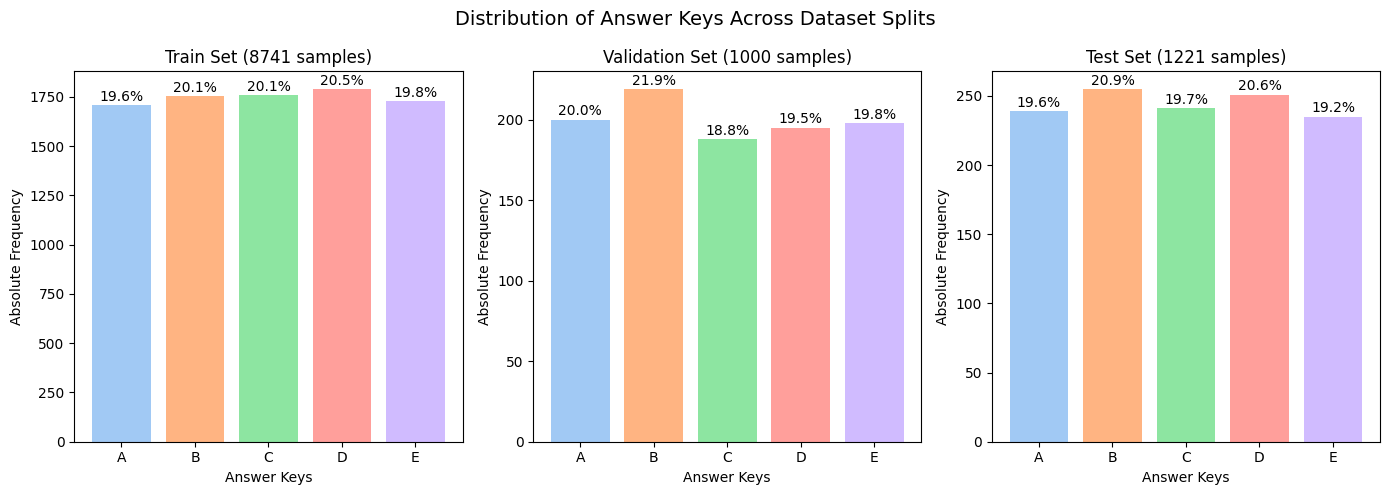

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

labels = sorted(list(unique_answers))

colors = sns.color_palette("pastel")[0:5]

for i, (split, data) in enumerate(datasets.items()):
    answer_counts = Counter([ex["answerKey"] for ex in data])
    
    # Sort by labels to ensure consistent order
    counts = [answer_counts[label] for label in labels]
    
    ax[i].bar(labels, counts, color=colors)
    ax[i].set_xlabel("Answer Keys")
    ax[i].set_ylabel("Absolute Frequency")
    ax[i].set_title(f"{split.capitalize()} Set ({len(data)} samples)")
    
    # Add percentage annotations
    total = sum(counts)
    for j, count in enumerate(counts):
        percentage = count / total * 100
        ax[i].annotate(f"{percentage:.1f}%", 
                      xy=(labels[j], count),
                      xytext=(0, 3),
                      textcoords="offset points",
                      ha='center')

plt.suptitle("Distribution of Answer Keys Across Dataset Splits", fontsize=14)
plt.tight_layout()

The distribution is relatively balanced, with a slight preference for answer `B` in the validation and test set.

I also plot the distribution of the number of characters in the questions.

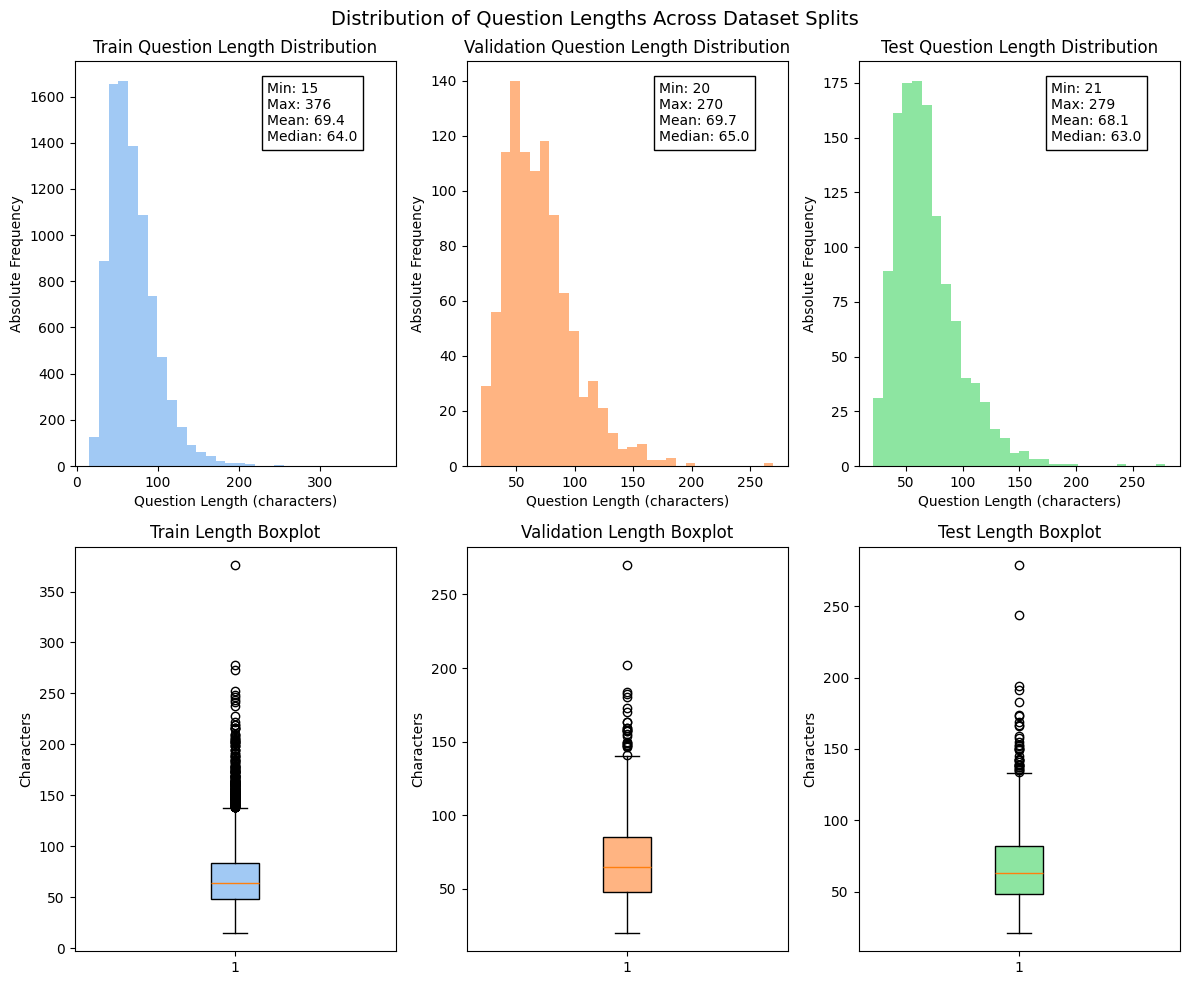

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

colors = sns.color_palette("pastel")[0:3]
all_question_lengths = []

for i, (split, data) in enumerate(datasets.items()):
  question_lengths = [len(ex["question"]) for ex in data]
  all_question_lengths.append(question_lengths)
  
  # Histogram plots (top row)
  axes[0, i].hist(question_lengths, bins=30, color=colors[i])
  axes[0, i].set_xlabel("Question Length (characters)")
  axes[0, i].set_ylabel("Absolute Frequency")
  axes[0, i].set_title(f"{split.capitalize()} Question Length Distribution")
  
  # Add statistics as text
  axes[0, i].text(0.6, 0.95, 
      f"Min: {min(question_lengths)}\nMax: {max(question_lengths)}\nMean: {np.mean(question_lengths):.1f}\nMedian: {np.median(question_lengths)}",
      transform=axes[0, i].transAxes,
      bbox=dict(facecolor='white'),
      verticalalignment='top')
  
  # Boxplot (bottom row)
  axes[1, i].boxplot(question_lengths, patch_artist=True)
  axes[1, i].set_title(f"{split.capitalize()} Length Boxplot")
  axes[1, i].set_ylabel("Characters")
  
  # Set the boxplot fill color
  for patch in axes[1, i].get_children():
    if isinstance(patch, plt.matplotlib.patches.PathPatch):
      patch.set_facecolor(colors[i])

plt.suptitle("Distribution of Question Lengths Across Dataset Splits", fontsize=14)
plt.tight_layout()

The questions are relatively short, with most of them having less than 100 characters. The three splits have a similar distribution and similar mean and median values.

The longest question has 376 characters which is good managable for both the Transformer model and the LLM.

I do the same check for the question choices and see that the distribution is similar to the questions. The longest question choice has 143 characters.

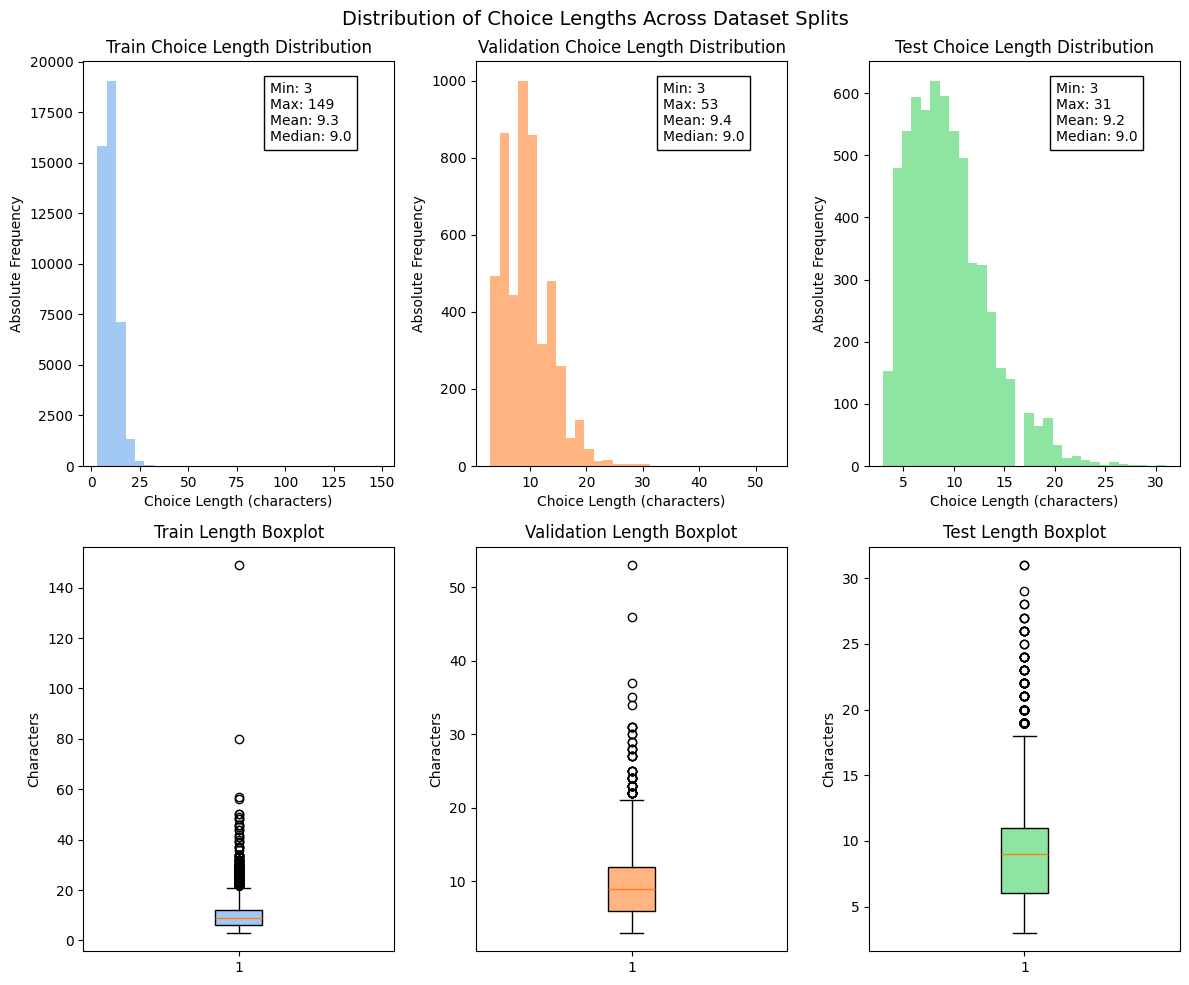

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

colors = sns.color_palette("pastel")[0:3]
all_choice_lengths = []

for i, (split, data) in enumerate(datasets.items()):
  choice_lengths = np.array([[len(choice) for choice in ex["choices"]["text"]] for ex in data]).flatten()
  all_choice_lengths.append(choice_lengths)
  
  # Histogram plots (top row)
  axes[0, i].hist(choice_lengths, bins=30, color=colors[i])
  axes[0, i].set_xlabel("Choice Length (characters)")
  axes[0, i].set_ylabel("Absolute Frequency")
  axes[0, i].set_title(f"{split.capitalize()} Choice Length Distribution")
  
  # Add statistics as text
  axes[0, i].text(0.6, 0.95, 
      f"Min: {min(choice_lengths)}\nMax: {max(choice_lengths)}\nMean: {np.mean(choice_lengths):.1f}\nMedian: {np.median(choice_lengths)}",
      transform=axes[0, i].transAxes,
      bbox=dict(facecolor='white'),
      verticalalignment='top')
  
  # Boxplot (bottom row)
  axes[1, i].boxplot(choice_lengths, patch_artist=True)
  axes[1, i].set_title(f"{split.capitalize()} Length Boxplot")
  axes[1, i].set_ylabel("Characters")
  
  # Set the boxplot fill color
  for patch in axes[1, i].get_children():
    if isinstance(patch, plt.matplotlib.patches.PathPatch):
      patch.set_facecolor(colors[i])

plt.suptitle("Distribution of Choice Lengths Across Dataset Splits", fontsize=14)
plt.tight_layout()

## Preprocessing

No real preprocessing is needed for the data, the tokenizers of the models can handle the text as it is.
The only thing I need to do is to convert the answer keys from letters to numbers, so that I can use them as labels for the models.

The DistilRoBERTa model supports any english text, including lowercase / uppercase, punctuation, etc.

Same goes for the Phi-LLM, which also accepts any english text.

I don't lowercase the text as it may contain important information such as `I` or `US` and because both models and its tokenizers are case-sensitive.

I also don't remove stopwords or punctuation as they may also contain important information for the model for answering the questions and because both models were trained on natural text.

Stemming or lemmatization is not necessary as the word embeddings and the models can handle different forms of words. Even more, it may be counterproductive as it may remove important information from the text such as time or location information.

Removal of unknown words is not necessary as both tokenizers used in the models use BPE which means that they can handle unknown words by breaking them down into smaller subwords or characters.

During training the Transformers, I will use padding to ensure all inputs in a batch have the same length.

The text in the dataset is already clean and doesn't contain any HTML tags I would need to remove and / or parse. 

### Input Formats

#### Transformer

For each question I construct five inputs, one for each of the five answer choices.
Each input is constructed by concatenating the question and candidate answer.
The questions are prefixed with "Q: " and the answer choices are prefixed with "A: ".

So one input to the Transformer looks like this (before tokenization): `<s>Q: <question></s><s>A: <answer choice></s>`.

The `Q: ` and `A: ` prefixes should help the model understand what the input is about and what it should do with it.

Truncation is not necessary as the longest question only has 376 characters and the longest answer choice has 143 characters.
The maximum input length of the model is 512 tokens, which is more than enough to handle the longest question and answer choice.

#### LLM

The LLM receives the question and answer choices in a textual format formatted for the Hugging Face pipeline.
The `user` prompt contains the question and all 5 answer choices in the following format:

```
Question: <question>
Choices:
A - <answer choice A>
B - <answer choice B>
C - <answer choice C>
D - <answer choice D>
E - <answer choice E>
```

The `system` prompt contains the instruction to answer the question and select the correct answer choice. The selected `system` prompt is:

```
You are a helpful assistant in a multiple-choice question-answering task. Answer the following multiple-choice commonsense reasoning questions with JUST THE LETTER of the correct answer (A, B, C, D, or E). Do absolutely NOT provide any explanations or additional information. If multiple answers are correct, choose the ONE that is most correct.
```

To ensure that the LLM understands the task, I provide a few examples of questions and their correct answers as initial messages.

These three parts are then passed to the Hugging Face pipeline, which constructs the prompt with the correct special tokens.

Here too, truncation is not necessary as the context window (128k tokens) is well above the maximum input length of the model.

### Prepare Data for Tansformers

I first load the tokenizer for the DistilRoBERTa model and test its encode-decode functionality.

In [9]:
roberta_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base", use_fast=False) # disable fast tokenizer for multi-threaded tokenization (https://stackoverflow.com/a/72926996)

In [10]:
encoded = roberta_tokenizer.encode("Q: question", "A: answer", return_tensors="pt")
decoded = roberta_tokenizer.decode(encoded[0])

print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")

assert encoded[0][0] == roberta_tokenizer.cls_token_id
assert encoded[0][-1] == roberta_tokenizer.sep_token_id

Encoded: tensor([[   0, 1864,   35,  864,    2,    2,  250,   35, 1948,    2]])
Decoded: <s>Q: question</s></s>A: answer</s>


In [11]:
def answer_key_to_index(answer_key):
  return ord(answer_key) - ord("A")

def index_to_answer_key(index):
  return chr(index + ord("A"))

assert answer_key_to_index("A") == 0
assert index_to_answer_key(0) == "A"

I then create three classes that serve as a wrapper for our data:
- `CommonsenseQADataset`: converts question-choice pairs into tokenized encodings without padding; returns a tuple of encodings (one for each question-choice pair) and the correct answer index
- `MultipleChoiceCollator`: manages batching by taking multiple dataset items and transforming them into properly formatted tensors for the model's training; it flattens all encodings from the batch, applies padding to ensure uniform sequence lengths, and returns a tuple of input_ids, attention_mask, and labels tensors
- `CommonsenseQADataModule`: integrates with PyTorch Lightning to streamline the entire data pipeline; encapsulating dataset creation and dataloader configuration

In [12]:
class CommonsenseQADataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length, debug=False):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.debug = debug

        self.question_prefix = "Q: "
        self.choice_prefix = "A: "
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        example = self.dataset[idx]
        question = example["question"]
        choices = example["choices"]["text"]
        
        answer_index = answer_key_to_index(example["answerKey"])

        # tokenize all question-answer pairs but don't pad yet
        encodings = []
        for choice in choices:
            encoding = self.tokenizer(
                self.question_prefix + question,
                self.choice_prefix + choice,
                truncation=False, # don't need truncation as all inputs are below max_length
                return_tensors=None # return lists, not tensors
            )

            if self.debug:
                # assert that max_length is respected
                assert len(encoding["input_ids"]) <= self.max_length, "Input exceeds max length"

            encodings.append(encoding)
            
        return encodings, answer_index

In [13]:
class MultipleChoiceCollator:
    def __init__(self, tokenizer, debug=False):
        self.tokenizer = tokenizer
        self.debug = debug
        
    def __call__(self, batch):
        # unpack the batch - each item is now a tuple of (encodings, label)
        encodings_list = [item[0] for item in batch] # list of lists of encodings
        labels = [item[1] for item in batch] # list of labels
        
        # flatten all encodings
        flat_encodings = [encoding for encodings in encodings_list for encoding in encodings]
        
        # pad to the longest in this batch
        padded_encodings = self.tokenizer.pad(
            flat_encodings,
            padding=True,
            return_tensors="pt"
        )

        num_choices = 5 # always 5 choices in this dataset
        batch_size = len(batch)

        # reshape back to [batch_size, num_choices, seq_length]
        input_ids = padded_encodings["input_ids"].view(batch_size, num_choices, -1)
        attention_mask = padded_encodings["attention_mask"].view(batch_size, num_choices, -1)
        
        # convert labels to tensor
        labels = torch.tensor(labels, dtype=torch.long)
        
        # return a tuple of (input_ids, attention_mask, labels)
        return input_ids, attention_mask, labels

In [14]:
class CommonsenseQADataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, valid_dataset, test_dataset, tokenizer, batch_size=16, max_length=512, num_workers=8, debug=False):
        super().__init__()
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_length = max_length
        self.num_workers = num_workers
        self.debug = debug
        
    def setup(self, stage=None):
        # create datasets
        if stage == 'fit' or stage is None:
            self.train_ds = CommonsenseQADataset(self.train_dataset, self.tokenizer, self.max_length, debug=self.debug)
            self.val_ds = CommonsenseQADataset(self.valid_dataset, self.tokenizer, self.max_length, debug=self.debug)
            
            if self.debug:
                # ensure datasets have expected properties
                assert len(self.train_ds) == len(self.train_dataset), "Train dataset length mismatch"
                assert len(self.val_ds) == len(self.valid_dataset), "Validation dataset length mismatch"
        
        if stage == 'test' or stage is None:
            self.test_ds = CommonsenseQADataset(self.test_dataset, self.tokenizer, self.max_length, debug=self.debug)

            if self.debug:
                assert len(self.test_ds) == len(self.test_dataset), "Test dataset length mismatch"
    
    def train_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            collate_fn=MultipleChoiceCollator(self.tokenizer, debug=self.debug),
            shuffle=True,
            num_workers=self.num_workers
        )
        return loader
    
    def val_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            collate_fn=MultipleChoiceCollator(self.tokenizer, debug=self.debug),
            shuffle=False,
            num_workers=self.num_workers
        )
        return loader
    
    def test_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            collate_fn=MultipleChoiceCollator(self.tokenizer, debug=self.debug),
            shuffle=False,
            num_workers=self.num_workers
        )
        return loader

In [15]:
max_input_length = 514
batch_size = 24

data_module = CommonsenseQADataModule(train, valid, test, roberta_tokenizer, batch_size=batch_size, max_length=max_input_length, debug=False)

I run a couple of tests on the dataset and dataloader to ensure that everything works as expected.

In [16]:
data_module.setup(stage="fit")
first_example, first_label = data_module.train_ds[0]

assert len(first_example) == 5, "Expected 5 choices"
assert type(first_label) == int, "Expected label to be an integer"
assert len(first_example[0]["input_ids"]) < max_input_length, "Input length exceeds max length"
assert len(first_example[0]["input_ids"]) == len(first_example[0]["attention_mask"]), "Input IDs and attention mask lengths do not match"

print("All assertions passed")

All assertions passed


In [17]:
train_loader = data_module.train_dataloader()
first_batch = next(iter(train_loader))
input_ids, attention_mask, labels = first_batch

assert input_ids.shape[0] == batch_size, "Batch size mismatch"
assert input_ids.shape[1] == 5, "Expected 5 choices"
assert input_ids.shape[2] <= max_input_length, "Input length exceeds max length"
assert attention_mask.shape == input_ids.shape, "Attention mask shape mismatch"
assert labels.shape == (batch_size,), "Labels shape mismatch"
assert labels.dtype == torch.long, "Labels dtype mismatch"
assert (labels.max() < 5 and labels.min() >= 0), "Label value out of range"

print("All assertions passed")

All assertions passed


### Prepare Data for LLM

Because I don't have train-loop for the LLM, I don't need to integrate it with PyTorch Lightning, thus no `DataModule` or collator is needed.

The `PhiPromptDataset` class is a simple wrapper around the dataset that formats the data for the LLM.
During initialization, for each example in the selected subset, it creates a conversation history by combining the system prompt, example conversations, and the current question formatted with lettered choices.
When getting an item, it returns the conversation history and the correct answer choice.

Unlike the `CommonsenseQADataset`, it does not return the text in a tokenized format, but rather the raw text.
This is because the HuggingFace pipeline will handle the tokenization internally.

In [23]:
class PhiPromptDataset(Dataset):
    system_prompt = "You are a helpful assistant in a multiple-choice question-answering task. Answer the following multiple-choice commonsense reasoning questions with JUST THE LETTER of the correct answer (A, B, C, D, or E). Do absolutely NOT provide any explanations or additional information. If multiple answers are correct, choose the ONE that is most correct."
    
    example_conversations = [
        [
            {"role": "user", "content": "Question: What do students do in school?\nChoices:\nA - they play outside\nB - they eat lunch\nC - they go home\nD - they learn and study\nE - they sleep"},
            {"role": "assistant", "content": "D"}
        ],
        [
            {"role": "user", "content": "Question: If you leave ice out in the sun, what will most likely happen to it?\nChoices:\nA - it will catch fire\nB - it will melt\nC - it will grow bigger\nD - it will turn into dust\nE - it will start glowing"},
            {"role": "assistant", "content": "B"}
        ],
        [
            {"role": "user", "content": "Question: If you are hungry, what is the most logical thing to do?\nChoices:\nA - take a nap\nB - go for a swim\nC - read a book\nD - buy new shoes\nE - eat some food"},
            {"role": "assistant", "content": "E"}
        ]
    ]
    
    def __init__(self, dataset, random_subset_size=1.0):
        self.dataset = dataset
        self.messages = []
        self.correct_answers = []
        
        self.prepare_data(random_subset_size)
    
    def prepare_data(self, random_subset_size=1.0):
        # if random_subset_size is 1.0, use the entire dataset
        if random_subset_size >= 1.0:
            subset = self.dataset
        else:
            # calculate the number of examples to include
            subset_size = max(1, int(len(self.dataset) * random_subset_size))
            
            # get random indices without replacement
            indices = random.sample(range(len(self.dataset)), subset_size)
            
            # create the subset
            subset = [self.dataset[i] for i in indices]
        
        for example in subset:
            question = example["question"]
            choices = example["choices"]["text"]
            correct_answer_idx = answer_key_to_index(example["answerKey"])
            
            # start with system prompt
            conversation = [
                {"role": "system", "content": self.system_prompt}
            ]
            
            # add example conversations
            for ex in self.example_conversations:
                conversation.extend(ex)
            
            # add the current question
            conversation.extend([
                {"role": "user", "content": f"Question: {question}\nChoices:\nA - {choices[0]}\nB - {choices[1]}\nC - {choices[2]}\nD - {choices[3]}\nE - {choices[4]}"}
            ])
            
            self.messages.append(conversation)
            self.correct_answers.append(correct_answer_idx)
    
    def __len__(self):
        return len(self.messages)
    
    def __getitem__(self, idx):
        return {
            "prompt": self.messages[idx],
            "correct_answer": self.correct_answers[idx]
        }

In [24]:
phi_prompt_valid = PhiPromptDataset(valid, random_subset_size=0.1) # around 100 samples is usually enough to see the model's performance
phi_prompt_test = PhiPromptDataset(test)

print(len(phi_prompt_valid[0]), len(phi_prompt_test[0]))
print(phi_prompt_valid[0])

2 2
{'prompt': [{'role': 'system', 'content': 'You are a helpful assistant in a multiple-choice question-answering task. Answer the following multiple-choice commonsense reasoning questions with JUST THE LETTER of the correct answer (A, B, C, D, or E). Do absolutely NOT provide any explanations or additional information. If multiple answers are correct, choose the ONE that is most correct.'}, {'role': 'user', 'content': 'Question: What do students do in school?\nChoices:\nA - they play outside\nB - they eat lunch\nC - they go home\nD - they learn and study\nE - they sleep'}, {'role': 'assistant', 'content': 'D'}, {'role': 'user', 'content': 'Question: If you leave ice out in the sun, what will most likely happen to it?\nChoices:\nA - it will catch fire\nB - it will melt\nC - it will grow bigger\nD - it will turn into dust\nE - it will start glowing'}, {'role': 'assistant', 'content': 'B'}, {'role': 'user', 'content': 'Question: If you are hungry, what is the most logical thing to do?\n

In [25]:
assert len(phi_prompt_valid) == 100, "Expected 100 samples in validation set"
assert len(phi_prompt_test) == len(test), "Test set length mismatch"

first_valid_example = phi_prompt_valid[0]
assert "prompt" in first_valid_example, "Expected 'prompt' key in example"
assert "correct_answer" in first_valid_example, "Expected 'correct_answer' key in example"
assert len(first_valid_example["prompt"]) > 1, "Expected more than 1 message in prompt"
assert type(first_valid_example["correct_answer"]) == int, "Expected correct_answer to be an integer"
assert first_valid_example["correct_answer"] in range(5), "Expected correct_answer to be in range [0, 4]"

print("All assertions passed")

All assertions passed


## Models

### 1) Pre-trained Transformer

I decided to use a distilled version of the [RoBERTa base model](https://huggingface.co/FacebookAI/roberta-base) for this task. The model is available on Hugging Face ([distilbert/distilroberta-base](https://huggingface.co/distilbert/distilroberta-base)) and was trained using the same procedure as DistilBERT.

RoBERTA is a popular alternative / superior to BERT. It was trained on a larger dataset and with more training steps, allowing it to outperform BERT on many NLP tasks. Using distillation, the model is smaller and faster than the original RoBERTa model, while still retaining most of its performance.

The model has 6 layers, 768 dimension and 12 heads, totalizing 82M parameters (compared to 125M parameters for RoBERTa-base). According to Hugging Face, the model runs on average twice as fast as Roberta-base with similar performance. The lower number of parameters allow for faster training and inference times, which is important for this project as I want to iterate quickly and test different models and hyperparameters. It also allows to fit the model on my 8GB GPU without running into memory issues.

The pre-trained transformer encoder processes the input tokens and produces a sequence of contextual encodings.
Dropout is applied on the representation of the first token (`<s>`).
These encodings are then passed to the classification head, which consists of two linear layers, layer normalization, and a ReLU activation function in between.
The hidden size of the linear layer is defined as a multiple of RoBERTa's hidden size (768).
The final outputs are the logits for each of the five answer choices.

The model is trained using the cross-entropy loss function.

For the optimizer, AdamW is used with a linear warming up learning rate scheduler.
The first 10% of the training steps are used for warming up the learning rate.
The initial LR is set to 1% and the final LR is set to 0.1% of the maximum LR.
Furthermore, a generally smaller LR (factor 0.05) is used for the pretrained transformer weights to reduce the risk of forgetting the pre-trained weights.

In [18]:
pretrained_distilroberta = AutoModel.from_pretrained("distilbert/distilroberta-base") # load weights from pretrained model

In [19]:
class RobertaMultipleChoiceModel(pl.LightningModule):
    def __init__(self, roberta_model, dropout_prob=0.1, learning_rate=1e-5, weight_decay=1e-3, use_layer_norm=True, hidden_size_multiplier=1.0, debug=False):
        super().__init__()
        
        self.save_hyperparameters(ignore=['roberta_model'])

        self.roberta = roberta_model
        self.roberta.train()

        hidden_size = int(hidden_size_multiplier * self.roberta.config.hidden_size)
        print(f"Hidden size: {hidden_size}")
        
        # custom classification head
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, hidden_size),
            nn.LayerNorm(hidden_size) if use_layer_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, 1)
        )
        
        # loss function
        self.criterion = nn.CrossEntropyLoss()
        
        # metrics
        self.train_accuracy = metrics.MulticlassAccuracy(num_classes=5)
        self.val_accuracy = metrics.MulticlassAccuracy(num_classes=5)
        self.test_accuracy = metrics.MulticlassAccuracy(num_classes=5)

        # for evaluation
        self.test_y = []
        self.test_y_pred = []
        self.test_y_logits = []
        self.test_y_confidence = []

        self.debug = debug
    
    def forward(self, input_ids, attention_mask):
        # input_ids and attention_mask have shape: [batch_size, num_choices, seq_length]
        this_batch_size, num_choices, seq_length = input_ids.shape

        if self.debug:
            assert num_choices == 5, "Number of choices should be 5 for CommonsenseQA"
            assert seq_length <= self.roberta.config.max_position_embeddings, "Sequence length exceeds model's max position embeddings"
            assert input_ids.shape == attention_mask.shape, "Input IDs and attention mask should have the same shape"
        
        # reshape to feed through the model
        input_ids = input_ids.view(-1, seq_length)  # [batch_size * num_choices, seq_length]
        attention_mask = attention_mask.view(-1, seq_length)  # [batch_size * num_choices, seq_length]

        if self.debug:
            assert input_ids.shape == attention_mask.shape, "Input IDs and attention mask should have the same shape"
            assert input_ids.shape[0] == attention_mask.shape[0] == this_batch_size * num_choices, "First dimension should be batch size * num choices"
            assert input_ids.shape[1] == attention_mask.shape[1] == seq_length, "Second dimension should be sequence length"
        
        # forward pass through base model
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        
        # get the first token (<s>) representation
        pooled_output = outputs.last_hidden_state[:, 0] # [batch_size * num_choices, hidden_size]
        pooled_output = self.dropout(pooled_output)

        if self.debug:
            assert pooled_output.shape == (this_batch_size * num_choices, self.roberta.config.hidden_size), "Pooled output should have shape [batch_size * num_choices, hidden_size]"
        
        # get logits for each choice
        logits = self.classifier(pooled_output)  # [batch_size * num_choices, 1]

        if self.debug:
            assert logits.shape == (this_batch_size * num_choices, 1), "Logits should have shape [batch_size * num_choices, 1]"
        
        # reshape logits back to [batch_size, num_choices]
        reshaped_logits = logits.view(this_batch_size, num_choices)

        if self.debug:
            assert reshaped_logits.shape == (this_batch_size, num_choices), "Reshaped logits should have shape [batch_size, num_choices]"
        
        return reshaped_logits
    
    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        
        self.train_accuracy.update(logits, labels)
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_accuracy.compute().item(), on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        
        self.val_accuracy.update(logits, labels)
        
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_accuracy.compute().item(), on_epoch=True, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)

        self.test_accuracy.update(logits, labels)

        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", self.test_accuracy.compute().item(), on_epoch=True)

        probs = torch.nn.functional.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        conf, _ = torch.max(probs, dim=1)

        self.test_y_pred.extend(preds.cpu().numpy())
        self.test_y.extend(labels.cpu().numpy())
        self.test_y_logits.extend(logits.cpu().numpy())
        self.test_y_confidence.extend(conf.cpu().numpy())

        return loss
    
    def reset_test_arrays(self):
        self.test_y = []
        self.test_y_pred = []
        self.test_y_logits = []
        self.test_y_confidence = []

    def configure_optimizers(self):
        # group parameters to apply a lower learning rate to the transformer layers
        transformer_lr_multiplier = 0.05
        transformer_lr = transformer_lr_multiplier * self.hparams.learning_rate
        classifier_lr = self.hparams.learning_rate

        optimizer_grouped_parameters = [
            {
                "params": [p for _, p in self.roberta.named_parameters()],
                "lr": transformer_lr,
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for _, p in self.classifier.named_parameters()],
                "lr": classifier_lr,
                "weight_decay": self.hparams.weight_decay,
            },
        ]

        optimizer = torch.optim.AdamW(optimizer_grouped_parameters)
        
        total_steps = self.trainer.estimated_stepping_batches
        warmup_steps = total_steps // 10
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[transformer_lr, classifier_lr],
            total_steps=total_steps,
            pct_start=warmup_steps / total_steps,
            div_factor=100,
            final_div_factor=1000,
            anneal_strategy="linear"
        )
        
        scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "frequency": 1,
        }
        
        return [optimizer], [scheduler_config]

### 2) Randomly Initialized Transformer

The randomly initialized transformer has the exact same architecture and model hyperparameters as the pre-trained transformer, but with no pre-trained weights.

In [20]:
# Create a randomly initialized model using the same configuration
random_config = AutoConfig.from_pretrained("distilbert/distilroberta-base")
random_initialized_roberta = AutoModel.from_config(random_config)

### 3) LLM - Phi-4-mini

For the LLM approach, I'll use Phi-4-mini-instruct, which is a 3.8 billion parameter decoder-only Transformer released by Microsoft in February 2025. The `-instruct` version of the model is designed to follow instructions and answer questions in a conversational manner. The model is available on Hugging Face ([microsoft/Phi-4-mini-instruct](https://huggingface.co/microsoft/Phi-4-mini-instruct)). The model achieves  a similar level of multilingual language understanding and reasoning ability as much larger models (https://huggingface.co/microsoft/Phi-4-mini-instruct#model-quality).

According to Microsoft, the model is "built upon synthetic data and filtered publicly available websites - with a focus on high-quality, reasoning dense data" ([source](https://ollama.com/library/phi4-mini)). It was trained on 5T tokens with a cutoff date of June 2024.

Unlike the previous models in this notebook, this model won't be fine-tuned but will use prompt engineering techniques.

The `text-generation` pipeline from Hugging Face will be used to feed the model with the question and answer choices and get the model's response.
The model will be used in a zero-shot setting, meaning that it will not be fine-tuned on the CommonsenseQA dataset but will rely on its pre-trained knowledge to answer the questions.

In [33]:
phi_model_name = "microsoft/Phi-4-mini-instruct"

phi_tokenizer = AutoTokenizer.from_pretrained(phi_model_name, fast=False) # disable fast tokenizer for multi-threaded tokenization (https://stackoverflow.com/a/72926996)

phi_model = AutoModelForCausalLM.from_pretrained(
    phi_model_name, 
    torch_dtype="auto",  
    trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [32]:
class PhiPromptEngineering:
    def __init__(self, model, tokenizer, debug=False):
        self.model = model
        self.debug = debug

        self.pipe = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=4, # only want really short answers - only the letter in the best case
            do_sample=False, # want deterministic output
            return_full_text=False # only return the newly generated text
        )
    
    def predict(self, prompt):
        full_response = self.pipe(prompt)[0]["generated_text"].strip()
        
        if self.debug:
            print(f"Full response: '{full_response}'")
        
        # extract just the first letter of the answer
        first_char = full_response[0].upper()
        if first_char in "ABCDE":
            answer = first_char
        else:
            raise ValueError(f"No valid answer choice (A-E) found in response: '{full_response}'")

        return answer_key_to_index(answer), full_response
    
    def evaluate(self, dataset, log_wandb=True):
        correct = 0
        total = 0
        accuracy = 0.0

        y = []
        y_pred = []
        raw_answers = []
        
        samples_count = len(dataset)
        for i in (pbar := trange(samples_count)):
            pbar.set_description(f"Sample {i}/{samples_count}")

            sample = dataset[i]
            prompt, correct_answer = sample["prompt"], sample["correct_answer"]
            predicted_index, raw_answer = self.predict(prompt)

            raw_answers.append(raw_answer)
            y.append(correct_answer)
            y_pred.append(predicted_index)
            
            total += 1
            if predicted_index == correct_answer:
                correct += 1

            accuracy = correct / total
            pbar.set_postfix({"accuracy": accuracy})

            if log_wandb:
                wandb.log({
                    "accuracy": accuracy
                })

        return accuracy, y, y_pred, raw_answers

## Training

### Hyperparameter Optimization

I use Weights & Biases Sweeps to perform hyperparameter optimization for the pre-trained transformer model. I run a sweep for 50 runs with the following hyperparameters:
- `learning_rate`: [1e-6, 1e-5.5, 1e-5, 1e-4.5, 1e-4]
- `weight_decay`: [1e-5, 1e-4, 1e-3]
- `dropout_prob`: [0.1, 0.2, 0.3, 0.4]
- `use_layer_norm`: [True, False]
- `hidden_size_multiplier`: [0.5, 1.0, 1.5] (defines the size of the hidden layer in the classification head in relation to the size of the transformer encoder)

A batch size of 24 is used for all runs, which is the maximum that fits on my GPU (8GB). The number of epochs is set to 50, but the training will stop earlier if the validation accuracy does not improve for 5 epochs (early stopping).
For some combinations of hyperparameters, I saw the highest validation accuracy after just a few epochs, while others even increased just until the end.

The best run is determined by the validation accuracy (also the early stopping metric).

To be able to resume training after a crash, I saved the model checkpoints every after every epoch. A checkpoint of the best epoch (determined also by the validation accuracy) is saved as well. The best checkpoint is uploaded to Weights & Biases after training.

If a Sweep was already performed, the checkpoint of the best run is downloaded and the model is loaded from there.

The randomly initialized transformer is trained with the same hyperparameters as the best pre-trained transformer as required by the project specification.

**Note**: You're not able to find any training or Sweep logs in the cell ouputs as I exported the notebook as a script to run it on GPUHub.

In [21]:
sweep_config = {
    "method": "bayes",
    "name": f"roberta-hyperparam-sweep-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
    "metric": {
        "name": "val_acc",
        "goal": "maximize"
    },
    "parameters": {
        "learning_rate": {
            "values": [10**-6, 10**-5.5, 10**-5, 10**-4.5, 10**-4]
        },
        'weight_decay': {
            "values": [1e-5, 1e-4, 1e-3]
        },
        "dropout_prob": {
            "values": [0.1, 0.2, 0.3, 0.4]
        },
        "use_layer_norm": {
            "values": [True, False]
        },
        "hidden_size_multiplier": {
            "values": [0.5, 1.0, 1.5]
        }
    }
}

In [22]:
def create_trainer(max_epochs, callbacks, logger):
  return pl.Trainer(
    max_epochs=max_epochs,
    accelerator="auto", # Uses GPU or MPS if available, otherwise CPU
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=10,
  )

In [23]:
def train(model, data_module, max_epochs, checkpoints_path, wandb_run_prefix=None, early_stopping_patience=None, debug=False, existing_run=None):
  run = existing_run if existing_run else wandb.init(entity=wandb_entity, project=wandb_project, name=f"{wandb_run_prefix}-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}")

  seed_everything(SEED, workers=True) # reset seed for every run

  if debug:
    max_epochs = 1

  if early_stopping_patience is None:
    early_stopping_patience = max_epochs + 1 # disable early stopping if not set

  data_module.setup("fit")

  # save a checkpoint for the best model
  best_checkpoint_callback = ModelCheckpoint(
      dirpath=checkpoints_path,
      filename="best-{epoch:02d}-{val_acc:.4f}",
      save_top_k=1,
      monitor="val_acc",
      mode="max"
  )

  # save a checkpoint for the most recent model
  regular_checkpoint_callback = ModelCheckpoint(
      dirpath=checkpoints_path,
      filename="latest-{epoch:02d}",
      save_top_k=1, # only keep the most recent checkpoint
      every_n_epochs=1, # save every epoch
  )

  early_stop_callback = EarlyStopping(
    monitor="val_acc",
    patience=early_stopping_patience,
    mode="max",
    check_finite=True # check for NaN or inf values
  )
  
  # log the learning rate
  lr_callback = LearningRateMonitor()

  wandb_logger = WandbLogger(
    experiment=run,
    log_model=(not debug) # only upload the checkpoint if not in debug mode
  )

  torch.set_float32_matmul_precision("high") # enables better performance on GPUHub's Nvidia A16 GPUs
  trainer = create_trainer(max_epochs, [best_checkpoint_callback, regular_checkpoint_callback, early_stop_callback, lr_callback], wandb_logger)

  trainer.fit(model, data_module)

  return trainer, best_checkpoint_callback.best_model_path, run

In [24]:
def run_sweep_trial():
    with wandb.init() as sweep_run:
        sweep_run.name = f"pretrained-roberta-sweep-{wandb.run.sweep_id}-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        config = wandb.config

        # create a unique checkpoint directory for this sweep run
        sweep_checkpoints_path = f"./checkpoints/sweep/{wandb.run.id}"
        os.makedirs(sweep_checkpoints_path, exist_ok=True)
        
        model = RobertaMultipleChoiceModel(
            roberta_model=pretrained_distilroberta,
            dropout_prob=config.dropout_prob,
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay,
            use_layer_norm=config.use_layer_norm,
            hidden_size_multiplier=config.hidden_size_multiplier,
            debug=False,
        )
        
        train(
            model=model,
            data_module=data_module,
            max_epochs=50,
            checkpoints_path=sweep_checkpoints_path,
            early_stopping_patience=5,
            debug=False,
            existing_run=sweep_run
        )

        sweep_run.finish()

In [27]:
if existing_sweep_id:
  # no need to create a new sweep, just use the existing one
  print(f"Using existing sweep with ID: {existing_sweep_id}")
  sweep_id = existing_sweep_id
else:
  # create a new sweep
  sweep_id = wandb.sweep(sweep_config, entity=wandb_entity, project=wandb_project)
  print(f"Created new sweep with ID: {sweep_id}")

Using existing sweep with ID: ef45hou8


In [28]:
if existing_sweep_id:
  print(f"Using existing sweep with ID: {existing_sweep_id}")
else:
  # run the sweep and wait for it to finish
  print(f"Created new sweep with ID: {sweep_id}")
  wandb.agent(sweep_id, function=run_sweep_trial, count=50, entity=wandb_entity, project=wandb_project)
  wandb.finish()

Using existing sweep with ID: ef45hou8


### 1) Load Pre-trained Transformer From Best Run

Using the sweep's ID, I load the best run from Weights & Biases and download the model checkpoint.

In [29]:
# get the best hyperparameters from the sweep
sweep = api.sweep(f"{wandb_entity}/{wandb_project}/{sweep_id}")
best_run = sweep.best_run()

# get the best hyperparameters
best_config = best_run.config
print(f"Best hyperparameters from run {best_run.id}:")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Weight Decay: {best_config['weight_decay']}")
print(f"Dropout Probability: {best_config['dropout_prob']}")
print(f"Use Layer Norm: {best_config['use_layer_norm']}")
print(f"Hidden Size Multiplier: {best_config['hidden_size_multiplier']}")

wandb: Sorting runs by -summary_metrics.val_acc


Best hyperparameters from run f9f0eyfl:
Learning Rate: 0.0001
Weight Decay: 1e-05
Dropout Probability: 0.1
Use Layer Norm: True
Hidden Size Multiplier: 1


In [30]:
best_pretrained_checkpoint = api.artifact(f"{wandb_entity}/{wandb_project}/model-{best_run.id}:best", type="model")
pretrained_roberta_best_checkpoint = best_pretrained_checkpoint.download(f"./checkpoints/pretrained/{best_run.id}-best-model")

pretrained_roberta_best_checkpoint = os.path.join(pretrained_roberta_best_checkpoint, "model.ckpt")

wandb: Downloading large artifact model-f9f0eyfl:best, 942.18MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.6


In [31]:
pretrained_roberta_model = RobertaMultipleChoiceModel.load_from_checkpoint(pretrained_roberta_best_checkpoint, roberta_model=pretrained_distilroberta)
pretrained_roberta_trainer = create_trainer(max_epochs=50, callbacks=None, logger=False) # create dummy trainer to allow later evaluation

Hidden size: 768


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### 2) Train Randomly Initialized Transformer with Best Hyperparameters

If a run for the randomly initialized transformer was already performed, I load also load the checkpoint and initialize the model from there.

If no run was performed yet, I train the model with the same hyperparameters as the best performing pre-trained transformer.
The only difference in the training procedure is the increased early stopping patience of 10 epochs, to see if the model can learn anything at all.

**Note**: For illustration purposes, I included the training logs in the outputs of the cell `[31]`. It shows the training using the same hyperparameters as the best pre-trained transformer, but with a patience of 15 epochs to allow for more training (else it would just always stop after 5 epochs). If you run the notebook end-to-end, you will not see any training logs as the run ID is already set to the best run of the random transformer. You can change the run ID to `None` at the top of the notebook to see the training logs again.
The run is uploaded to [Weights & Biases](https://wandb.ai/dhodel-hslu-nlp/hslu-fs25-nlp-qa-transformers/workspace?nw=zyqoi7d1pw) but isn't used for evaluation due to its worse val accuracy than the run I've selected.

In [32]:
if existing_random_initialized_model_run_id is not None:
  print(f"Using existing random initialized model run ID: {existing_random_initialized_model_run_id}")

  existing_random_initialized_model_run = api.run(f"{wandb_entity}/{wandb_project}/{existing_random_initialized_model_run_id}")
  best_random_initialized_checkpoint = api.artifact(f"{wandb_entity}/{wandb_project}/model-{existing_random_initialized_model_run.id}:best", type="model")

  randomly_initialized_roberta_best_checkpoint = best_random_initialized_checkpoint.download(f"./checkpoints/random/{existing_random_initialized_model_run.id}-best-model")
  randomly_initialized_roberta_best_checkpoint = os.path.join(randomly_initialized_roberta_best_checkpoint, "model.ckpt")

  random_initialized_roberta_model = RobertaMultipleChoiceModel.load_from_checkpoint(randomly_initialized_roberta_best_checkpoint, roberta_model=random_initialized_roberta)
  randomly_initialized_roberta_trainer = create_trainer(max_epochs=50, callbacks=None, logger=False) # create dummy trainer to allow later evaluation
else:
  print("No existing random initialized model run ID provided.")

Using existing random initialized model run ID: 95gtdhkj


wandb: Downloading large artifact model-95gtdhkj:best, 942.18MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.7
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Hidden size: 768


In [33]:
if existing_random_initialized_model_run_id is None: # only initialize model if we don't already have loaded a trained checkpoint
    print("Initializing a new random initialized model with the same best hyperparameters")

    random_initialized_roberta_model = RobertaMultipleChoiceModel(
        roberta_model=random_initialized_roberta, 
        dropout_prob=best_config['dropout_prob'], 
        learning_rate=best_config['learning_rate'], 
        weight_decay=best_config['weight_decay'], 
        use_layer_norm=best_config['use_layer_norm'], 
        hidden_size_multiplier=best_config['hidden_size_multiplier'],
        debug=False
    )

In [31]:
if existing_random_initialized_model_run_id is None: # only train if we don't already have loaded a trained checkpoint
  random_initialized_checkpoints_path = "./checkpoints/random-initialized"
  os.makedirs(random_initialized_checkpoints_path, exist_ok=True)

  randomly_initialized_roberta_trainer, randomly_initialized_roberta_best_checkpoint, random_initialized_run = train(
    model=random_initialized_roberta_model,
    data_module=data_module,
    max_epochs=50,
    checkpoints_path=random_initialized_checkpoints_path,
    early_stopping_patience=20, # increased patience for random initialization to allow for more training as a low number never encouraged any learning
    wandb_run_prefix="random-initialized-roberta-best-params",
    existing_run=None,
  )

  random_initialized_run.finish()
else:
  print("Using existing random initialized model run ID, skipping training.")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/david/miniconda3/envs/nlp-test/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/david/git/HSLU.NLP/course_projects/project_2/checkpoints/random-initialized exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | roberta    | RobertaModel     | 82.1 M | train
1 | dropout    | Dropout          | 0      | train
2 | classifier | Sequential       | 592 K  | train
3 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
82.7 M    Trainable params
0         Non-trainable params
82.7 M    Total params
330.845   Total estimated model params size (MB)
128       Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████
lr-AdamW/pg1,▁▂▆▆█████▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅
lr-AdamW/pg2,▁▂▂▃▅▆▇▇▇██████████▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅
train_acc,▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▅▆▇█
train_loss_epoch,█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▅▅▄▃▂▁
train_loss_step,█▇▇███▇▇██████▇▇█▇█▇▇▇█▇▇▇▇▇▇█▅▅▆▇▆▆▅▃▄▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▄██▇▆▅▅▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▅▇█
epoch,21
lr-AdamW/pg1,0.0


### 3) Prompt Engineering with Phi LLM

For the Phi model, I don't need a training routine since we're only using prompt engineering and don't tune any weights.

For trying out different prompt, I run the mode against a subset of the validation set as the trend of the performance emerges quickly and always follows the same pattern.

What I've tried:
- Give between 3 and 6 example questions and answers for instruction tuning
- Include easier and harder examples
- Add clarity about tie-breaking: `If multiple options seem correct, choose the MOST appropriate or complete answer`
- Chain-of-thought prompting
- Encourage double-checking: `Before submitting your answer, verify it makes logical sense and is the most appropriate choice for the question.`
- Encourage checking all answers: `Before submitting your answer, check all options carefully.`

In conclusion, the simple prompt with just 3 examples to tune it to the task seems to work best.
All other additions made only a small difference, mostly negative.
The chain-of-thought prompting also made the evaluating much slower (factor ~50) due to the increased number of tokens in the prompt and the model's output.

The system instruction used is:

```
You are a helpful assistant in a multiple-choice question-answering task. Answer the following multiple-choice commonsense reasoning questions with JUST THE LETTER of the correct answer (A, B, C, D, or E). Do absolutely NOT provide any explanations or additional information. If multiple answers are correct, choose the ONE that is most correct.
```

The model is only evaluated when no results are found yet in the specified run.
Else, the results are loaded from the Weights & Biases run.

In [34]:
phi_prompt_engineering = PhiPromptEngineering(
    model=phi_model,
    tokenizer=phi_tokenizer,
    debug=False
)

Device set to use cuda:0


In [7]:
if existing_llm_run_id is not None: # load existing run
    print(f"Using existing LLM run ID: {existing_llm_run_id}")
    llm_run = api.run(f"{wandb_entity}/{wandb_project}/{existing_llm_run_id}")
else: # initialize a new run
    llm_run = wandb.init(
        entity=wandb_entity,
        project=wandb_project,
        name=f"phi-prompt-engineering-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
        reinit=True,
        config={
            "model_name": phi_model_name,
            "system_prompt": phi_prompt_valid.system_prompt,
        }
    )

    print(f"Created new LLM run with ID: {llm_run.id}")

Using existing LLM run ID: hxgu5yfh


In [8]:
if existing_llm_run_id is None: # only evaluate if we don't already have loaded a trained checkpoint
    phi_accuracy, y, y_pred, raw_answers = phi_prompt_engineering.evaluate(phi_prompt_valid, log_wandb=True)

    llm_run.log_artifact(wandb.Artifact(
        name=f"{llm_run.id}-val-results",
        type="results",
        metadata={
            "accuracy": phi_accuracy,
            "raw_answers": raw_answers,
            "y_true": y,
            "y_pred": y_pred
        }
    ))

    llm_run.finish()
    existing_llm_run_id = llm_run.id
else: # load existing run
    artifact = api.artifact(f"{wandb_entity}/{wandb_project}/{llm_run.id}-val-results:latest", type="results")
    phi_accuracy, y, y_pred, raw_answers = artifact.metadata["accuracy"], artifact.metadata["y_true"], artifact.metadata["y_pred"], artifact.metadata["raw_answers"]

    print(f"Loaded existing LLM run with val accuracy: {phi_accuracy}")

Loaded existing LLM run with val accuracy: 0.64


## Evaluation

### Calculate Accuracy

Here I calculate the accuracy of all three models on the test set.

For the Phi model, when there are already results in the Weights & Biases run, I load them from there.
Else, I run the model on the test set and save the results to Weights & Biases.
I also run the model on the full validation (not just a subset) and the train set to see how it performs on the other splits.

In [34]:
# disable wandb logging for the trainers
pretrained_roberta_trainer.logger = False
randomly_initialized_roberta_trainer.logger = False

In [35]:
with warnings.catch_warnings():
    # ignore warnings about loading the checkpoints on a different device and without the same callbacks
    warnings.filterwarnings("ignore", message=".*callbacks used to create the checkpoint.*")
    warnings.filterwarnings("ignore", message=".*dirpath has changed from.*")

    # evaluate pretrained model
    pretrained_roberta_model.reset_test_arrays()
    pretrained_test_results = pretrained_roberta_trainer.test(pretrained_roberta_model, datamodule=data_module, ckpt_path=pretrained_roberta_best_checkpoint)

    # evaluate randomly initialized model
    random_initialized_roberta_model.reset_test_arrays()
    random_test_results = randomly_initialized_roberta_trainer.test(random_initialized_roberta_model, datamodule=data_module, ckpt_path=randomly_initialized_roberta_best_checkpoint)

    # extract test results
    pretrained_test_labels = pretrained_roberta_model.test_y
    pretrained_test_preds = pretrained_roberta_model.test_y_pred
    pretrained_test_logits = pretrained_roberta_model.test_y_logits
    pretrained_test_confidences = pretrained_roberta_model.test_y_confidence

    random_test_labels = random_initialized_roberta_model.test_y
    random_test_preds = random_initialized_roberta_model.test_y_pred
    random_test_logits = random_initialized_roberta_model.test_y_logits
    random_test_confidences = random_initialized_roberta_model.test_y_confidence

Restoring states from the checkpoint path at ./checkpoints/pretrained/f9f0eyfl-best-model/model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./checkpoints/pretrained/f9f0eyfl-best-model/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5222641825675964
        test_loss           2.2655200958251953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at ./checkpoints/random/95gtdhkj-best-model/model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./checkpoints/random/95gtdhkj-best-model/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.19009321928024292
        test_loss           1.6094815731048584
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [10]:
try:
  phi_test_results_artifact = api.artifact(f"{wandb_entity}/{wandb_project}/{llm_run.id}-test-results:latest", type="results")
  phi_test_accuracy, phi_test_labels, phi_test_preds, phi_test_raw_answers = phi_test_results_artifact.metadata["accuracy"], phi_test_results_artifact.metadata["y_true"], phi_test_results_artifact.metadata["y_pred"], phi_test_results_artifact.metadata["raw_answers"]

  print(f"Loaded existing LLM test results with accuracy: {phi_test_accuracy}")
except:
  phi_test_results_artifact = None
  print("Artifact with test results not found")

try:
  phi_full_val_results_artifact = api.artifact(f"{wandb_entity}/{wandb_project}/{llm_run.id}-full-val-results:latest", type="results")
  phi_full_val_accuracy, phi_full_val_labels, phi_full_val_preds, phi_full_val_raw_answers = phi_full_val_results_artifact.metadata["accuracy"], phi_full_val_results_artifact.metadata["y_true"], phi_full_val_results_artifact.metadata["y_pred"], phi_full_val_results_artifact.metadata["raw_answers"]

  print(f"Loaded existing LLM full val results with accuracy: {phi_full_val_accuracy}")
except:
  phi_full_val_results_artifact = None
  print("Artifact with full val results not found")

try:
  phi_train_results_artifact = api.artifact(f"{wandb_entity}/{wandb_project}/{llm_run.id}-train-results:latest", type="results")
  phi_train_accuracy, phi_train_labels, phi_train_preds, phi_train_raw_answers = phi_train_results_artifact.metadata["accuracy"], phi_train_results_artifact.metadata["y_true"], phi_train_results_artifact.metadata["y_pred"], phi_train_results_artifact.metadata["raw_answers"]

  print(f"Loaded existing LLM train results with accuracy: {phi_train_accuracy}")
except:
  phi_train_results_artifact = None
  print("Artifact with train results not found")

Loaded existing LLM test results with accuracy: 0.678951678951679
Loaded existing LLM full val results with accuracy: 0.684
Loaded existing LLM train results with accuracy: 0.6488960073218167


In [12]:
if phi_test_results_artifact is None:
  print("No existing test results artifact found, creating a new one")

  with wandb.init(entity=wandb_entity, project=wandb_project, id=existing_llm_run_id, resume="must") as resumed_llm_run:
    phi_test_accuracy, phi_test_labels, phi_test_preds, phi_test_raw_answers = phi_prompt_engineering.evaluate(phi_prompt_test, log_wandb=False)

    resumed_llm_run.log_artifact(wandb.Artifact(
      name=f"{llm_run.id}-test-results",
      type="results",
      metadata={
          "accuracy": phi_test_accuracy,
          "raw_answers": phi_test_raw_answers,
          "y_true": phi_test_labels,
          "y_pred": phi_test_preds
      }
    ))
else:
  print("Existing test results artifact found, skipping evaluation")

if phi_full_val_results_artifact is None:
  print("No existing full val results artifact found, creating a new one")

  with wandb.init(entity=wandb_entity, project=wandb_project, id=existing_llm_run_id, resume="must") as resumed_llm_run:
    phi_prompt_full_val = PhiPromptDataset(valid)
    phi_full_val_accuracy, phi_full_val_labels, phi_full_val_preds, phi_full_val_raw_answers = phi_prompt_engineering.evaluate(phi_prompt_full_val, log_wandb=False)

    resumed_llm_run.log_artifact(wandb.Artifact(
      name=f"{llm_run.id}-full-val-results",
      type="results",
      metadata={
          "accuracy": phi_full_val_accuracy,
          "raw_answers": phi_full_val_raw_answers,
          "y_true": phi_full_val_labels,
          "y_pred": phi_full_val_preds
      }
    ))
else:
  print("Existing full val results artifact found, skipping evaluation")

if phi_full_val_results_artifact is None:
  print("No existing train results artifact found, creating a new one")

  with wandb.init(entity=wandb_entity, project=wandb_project, id=existing_llm_run_id, resume="must") as resumed_llm_run:
    phi_prompt_train = PhiPromptDataset(train)
    phi_train_accuracy, phi_train_labels, phi_train_preds, phi_train_raw_answers = phi_prompt_engineering.evaluate(phi_prompt_train, log_wandb=False)

    resumed_llm_run.log_artifact(wandb.Artifact(
      name=f"{llm_run.id}-train-results",
      type="results",
      metadata={
          "accuracy": phi_train_accuracy,
          "raw_answers": phi_train_raw_answers,
          "y_true": phi_train_labels,
          "y_pred": phi_train_preds
      }
    ))
else:
  print("Existing train results artifact found, skipping evaluation")

Existing test results artifact found, skipping evaluation
Existing full val results artifact found, skipping evaluation
Existing train results artifact found, skipping evaluation


### Visualize Results

The Phi-4-mini LLM performed the best with a test-set accuracy of 67.8%, followed by the pretrained and finetuned DistilRoBERTa model with 52.2% and the randomly initialized DistilRoBERTa model with 19.0%.
The randomly initialized model performed significantly worse than the two pretrained models with a performance at chance level.

The confusion matrices show that the randomly initialized model is not able to distinguish between the different answer choices and predicts all of them with around equal probability.
The other models have a much more pronounced diagonal, indicating that they are able to distinguish between the different answer choices.
While for the pretrained model the confusion matrix is relatively balanced, the Phi-4-mini LLM has a strong under-representation of answer choice `E`.

In [50]:
# check that all test label and prediction arrays have the same length
assert len(pretrained_test_labels) == len(pretrained_test_preds) == len(random_test_labels) == len(random_test_preds) == len(phi_test_labels) == len(phi_test_preds), "All test label and prediction arrays should have the same length"

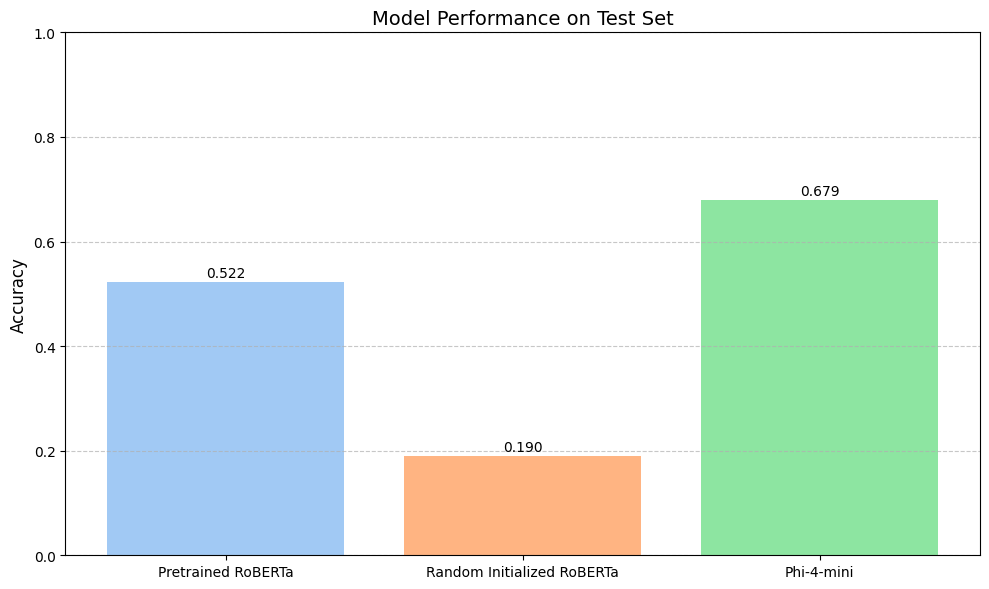

In [ ]:
os.makedirs("graphics", exist_ok=True)

model_names = ['Pretrained RoBERTa', 'Random Initialized RoBERTa', 'Phi-4-mini']
accuracies = [
    pretrained_test_results[0]['test_acc'],
    random_test_results[0]['test_acc'],
    phi_test_accuracy
]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=sns.color_palette("pastel"))
plt.ylim(0, 1.0)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance on Test Set', fontsize=14)
plt.xticks()

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., 
             bar.get_height() + 0.01, 
             f'{acc:.3f}', 
             ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('graphics/model_comparison.svg', bbox_inches='tight')
plt.show()

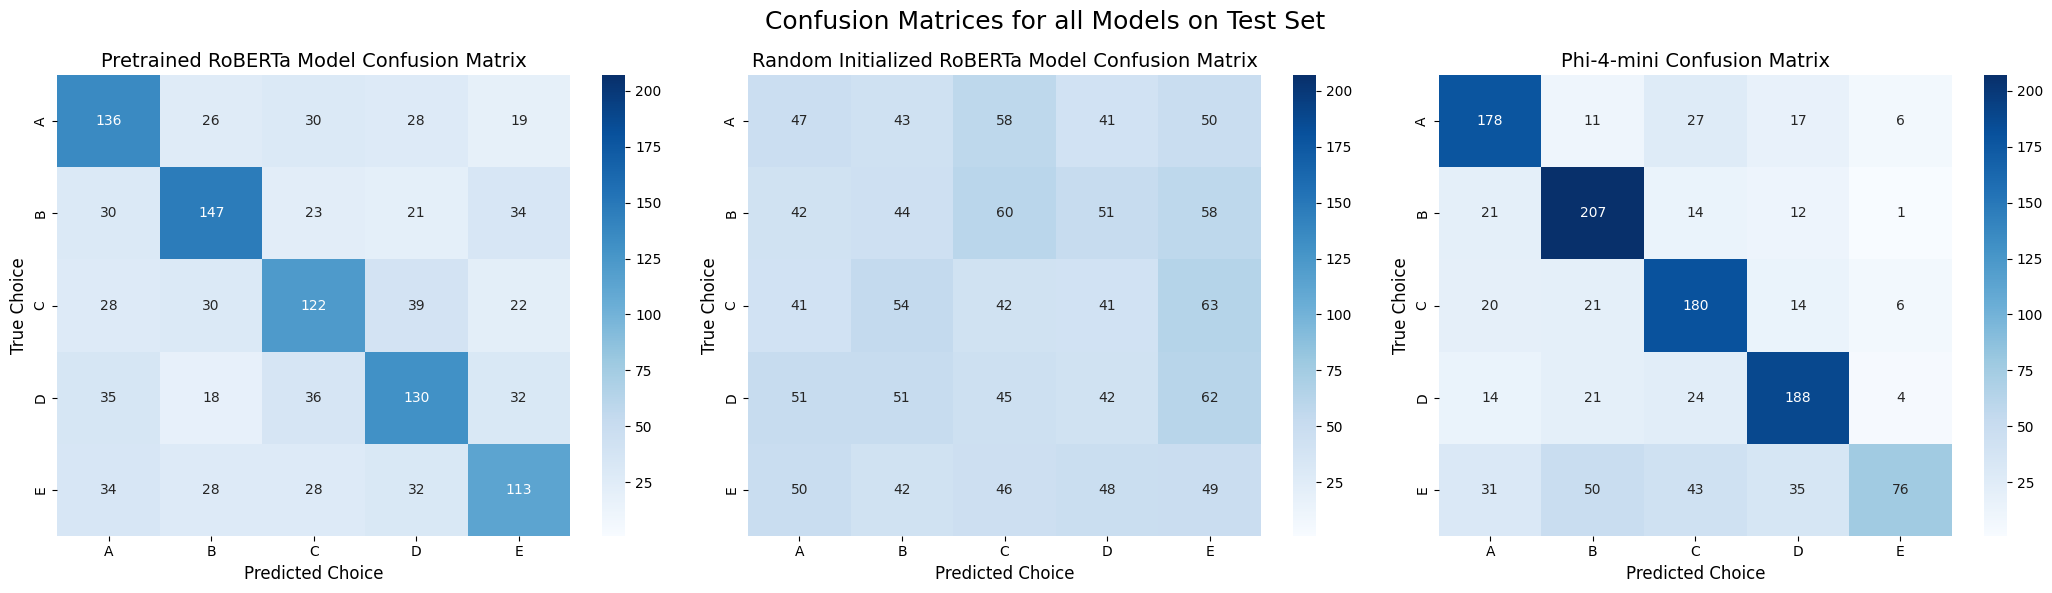

In [ ]:
label_mapping = {i: chr(65 + i) for i in range(5)}  # 0->A, 1->B, etc.
label_names = list(label_mapping.values())

pretrained_cm = confusion_matrix(pretrained_test_labels, pretrained_test_preds)
random_cm = confusion_matrix(random_test_labels, random_test_preds)
phi_cm = confusion_matrix(phi_test_labels, phi_test_preds)

# determine the global min and max values for consistent scaling
global_vmin = min(pretrained_cm.min(), random_cm.min(), phi_cm.min())
global_vmax = max(pretrained_cm.max(), random_cm.max(), phi_cm.max())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

sns.heatmap(pretrained_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names, 
            ax=ax1, vmin=global_vmin, vmax=global_vmax)
ax1.set_title("Pretrained RoBERTa Model Confusion Matrix", fontsize=14)
ax1.set_xlabel("Predicted Choice", fontsize=12)
ax1.set_ylabel("True Choice", fontsize=12)

sns.heatmap(random_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names, 
            ax=ax2, vmin=global_vmin, vmax=global_vmax)
ax2.set_title("Random Initialized RoBERTa Model Confusion Matrix", fontsize=14)
ax2.set_xlabel("Predicted Choice", fontsize=12)
ax2.set_ylabel("True Choice", fontsize=12)

sns.heatmap(phi_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names, 
            ax=ax3, vmin=global_vmin, vmax=global_vmax)
ax3.set_title("Phi-4-mini Confusion Matrix", fontsize=14)
ax3.set_xlabel("Predicted Choice", fontsize=12)
ax3.set_ylabel("True Choice", fontsize=12)

fig.suptitle("Confusion Matrices for all Models on Test Set", fontsize=18)
plt.tight_layout()
plt.savefig("graphics/confusion_matrices_all_models.svg", bbox_inches="tight")
plt.show()

#### Compare LLM Performance on Different Sets

Here I compare the performance of the Phi-4-mini LLM on the different splits (train, the subset of the validation set used for tuning, the full validation set and the test set).

The difference between the best (full validation, 68.4%) and the worst split (validation subset, 64.0%) is not significant and can be attributed to random fluctuations of the questions in the different splits.
The test split performs slightly better than the full validation split.

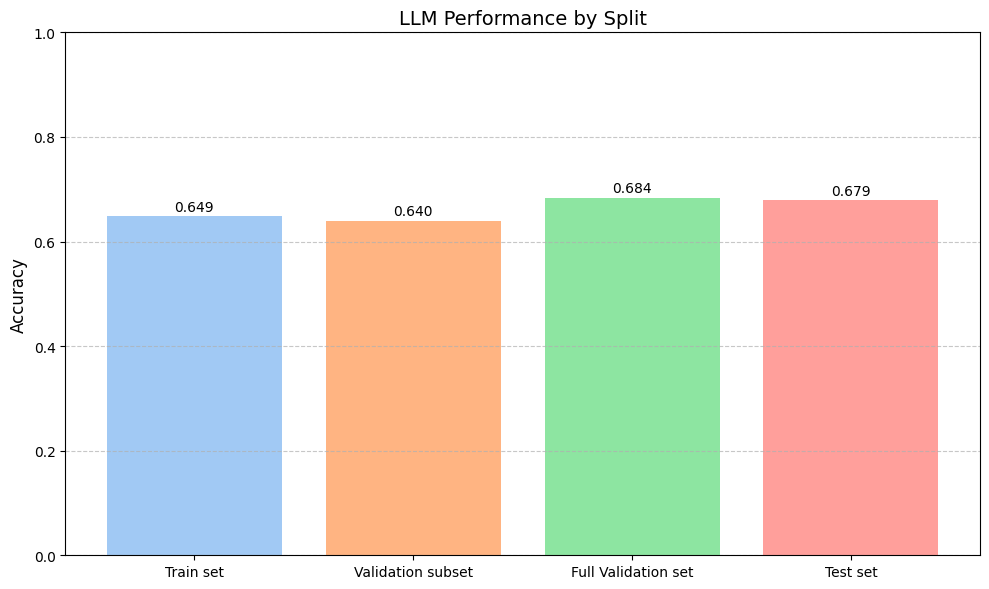

In [13]:
labels = ["Train set", "Validation subset", "Full Validation set", "Test set"]
accuracies = [
    phi_train_accuracy,
    phi_accuracy,
    phi_full_val_accuracy,
    phi_test_accuracy
]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies, color=sns.color_palette("pastel"))
plt.ylim(0, 1.0)
plt.ylabel('Accuracy', fontsize=12)
plt.title('LLM Performance by Split', fontsize=14)
plt.xticks()

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., 
             bar.get_height() + 0.01, 
             f'{acc:.3f}', 
             ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('graphics/phi_split_comparison.svg', bbox_inches='tight')
plt.show()

### Training Curves

For the Transformers, I plot the training and validation accuracy over the epochs.

We see that both runs terminated really early, after only 5 respectively 6 epochs.

The randomly initialized model was not able to learn anything and the validation accuracy even decresed from the starting point.
The training accuracy was also not able to improve significantly.
In a different run where I allowd the model to train longer (with patience of 15 epochs), the train accuracy indeed started to increase, but the validation accuracy was still decreasing.

The pretrained model was able to learn quickly and reached its peak performance after just 2 epochs.
The gap between training and validation accuracy started out small, but increased over time.
While the validation accuracy peaked at around 53%, the training accuracy reached a value of over 80% at the end of training.

The validationa accuracies of both models are very close to the test accuracies (52.2% vs. 53.4% and 19.0% vs. 19.8%), indicating that the models are not overfitting the validation data.

In [53]:
random_history = existing_random_initialized_model_run.history(samples=10000) # need to specify a large number of samples to get the full history
pretrained_history = best_run.history(samples=10000)

In [54]:
random_highest_val_acc = np.max(random_history["val_acc"])
pretrained_highest_val_acc = np.max(pretrained_history["val_acc"])

random_highest_train_acc = np.max(random_history["train_acc"])
pretrained_highest_train_acc = np.max(pretrained_history["train_acc"])

print(f"Random Initialized Model - Highest Validation Accuracy: {random_highest_val_acc:.4f}")
print(f"Pretrained Model - Highest Validation Accuracy: {pretrained_highest_val_acc:.4f}")

print(f"Random Initialized Model - Highest Training Accuracy: {random_highest_train_acc:.4f}")
print(f"Pretrained Model - Highest Training Accuracy: {pretrained_highest_train_acc:.4f}")

Random Initialized Model - Highest Validation Accuracy: 0.1986
Pretrained Model - Highest Validation Accuracy: 0.5345
Random Initialized Model - Highest Training Accuracy: 0.2006
Pretrained Model - Highest Training Accuracy: 0.8229


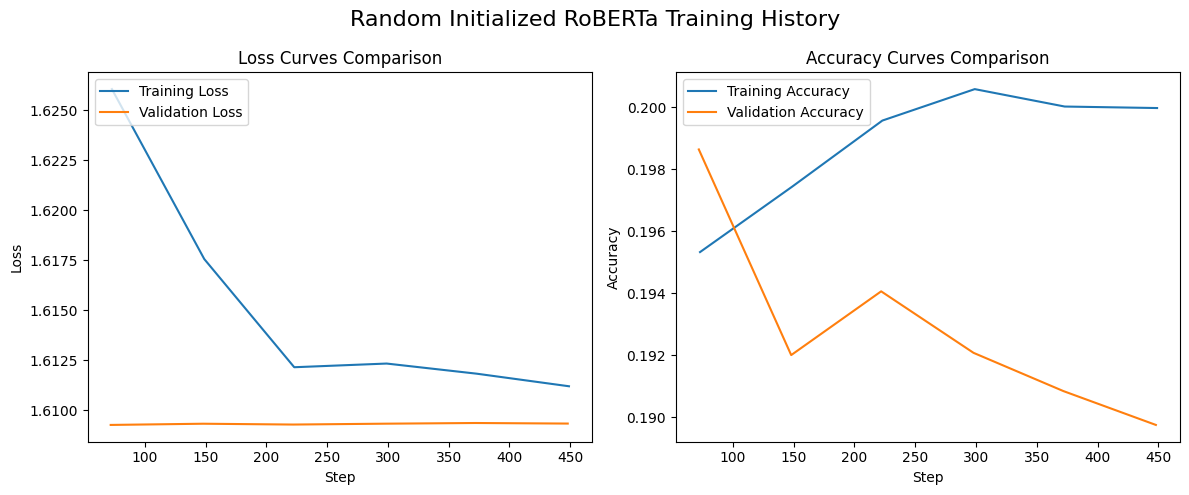

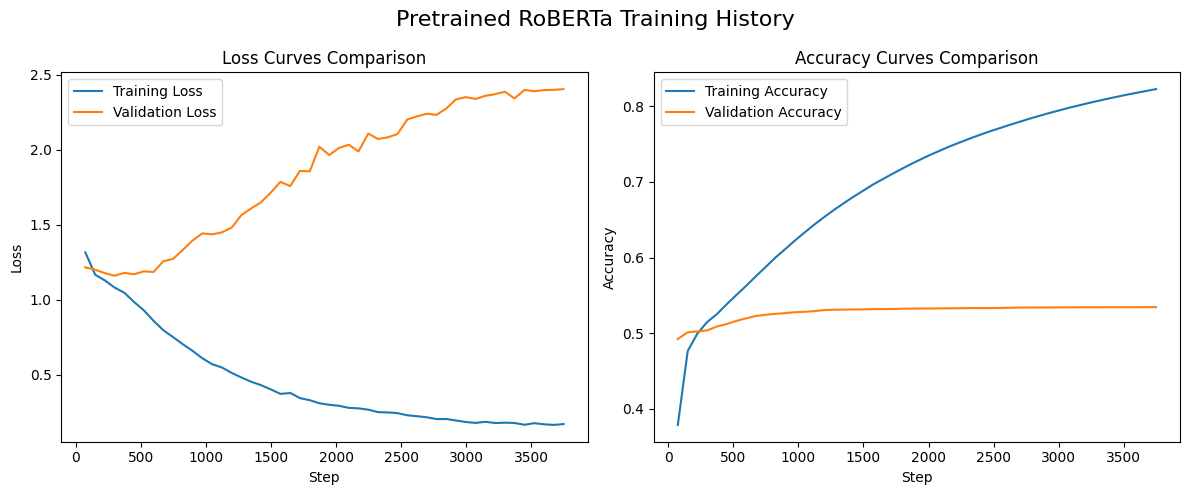

In [55]:
def plot_train_history(run_history, title):
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(run_history['train_loss_epoch'].dropna(), label='Training Loss')
  plt.plot(run_history['val_loss'].dropna(), label='Validation Loss')
  plt.xlabel('Step')
  plt.ylabel('Loss')
  plt.title('Loss Curves Comparison')
  plt.legend(loc="upper left")

  plt.subplot(1, 2, 2)
  plt.plot(run_history['train_acc'].dropna(), label='Training Accuracy')
  plt.plot(run_history['val_acc'].dropna(), label='Validation Accuracy')
  plt.xlabel('Step')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Curves Comparison')
  plt.legend(loc="upper left")

  plt.suptitle(title, fontsize=16)

  plt.tight_layout()
  plt.show()

plot_train_history(random_history, "Random Initialized RoBERTa Training History")
plot_train_history(pretrained_history, "Pretrained RoBERTa Training History")

### Error Analysis

In this section, I analyze the performance of the three models in detail to understand their strengths, weaknesses, and error patterns.

Since the randomly initialized model didn't seem to learn anything at all and just predicted randomly, I won't do any error analysis on it.
I therefore only analyze the pre-trained Transformer and the LLM.

#### LLM Raw Answers

The Phi-4-mini LLM sometimes generates responses containing more than just the single letter answer, despite prompt instructions. I analyze these cases to understand if there's a pattern in when the model deviates from instructions and whether these deviations correlate with performance.

Out of the responses with more than one character:
- 13 were correct answers (52%)
- 12 were incorrect answers (48%)

This suggests that when the model provides longer answers, its accuracy is worse compared to its overall performance. 

The model sometimes includes the full answer choice (e.g., "E slow down") or multiple answer choices (e.g., "A or B"). In these cases, the model seems to be uncertain about the correct answer and tries to hedge its response, despite the instruction to choose the most appropriate answer if it's not sure.

In [56]:
# get the indices of the answers where the model wrote a raw answer with more than 1 character
phi_long_answers = [(i, answer) for i, answer in enumerate(phi_test_raw_answers) if len(answer) > 1]
correct_answers = [(i, answer) for i, answer in phi_long_answers if phi_test_preds[i] == phi_test_labels[i]]
wrong_answers = [(i, answer) for i, answer in phi_long_answers if phi_test_preds[i] != phi_test_labels[i]]

print(f"Number of answers with more than 1 character: {len(phi_long_answers)}")
print(f"Number of correct answers: {len(correct_answers)}")
print(f"Number of wrong answers: {len(wrong_answers)}")
print()

for i, answer in phi_long_answers:
    print(f"Model's Answer: '{answer}'")
    print(f"Prompt: {phi_prompt_test[i]['prompt'][-1]}")
    print(f"Correct Answer: {index_to_answer_key(phi_test_labels[i])}")
    print(f"Predicted Answer: {index_to_answer_key(phi_test_preds[i])}")
    print()

Number of answers with more than 1 character: 25
Number of correct answers: 13
Number of wrong answers: 12

Model's Answer: 'E slow down'
Prompt: {'role': 'user', 'content': 'Question: Sean was in a rush to get home, but the light turned yellow and he was forced to do what?\nChoices:\nA - take time\nB - dawdle\nC - go slowly\nD - ocean\nE - slow down'}
Correct Answer: E
Predicted Answer: E

Model's Answer: 'A get money'
Prompt: {'role': 'user', 'content': 'Question: What must someone do before they shop?\nChoices:\nA - get money\nB - have money\nC - bring cash\nD - go to market\nE - bring cash'}
Correct Answer: A
Predicted Answer: A

Model's Answer: 'B good

C'
Prompt: {'role': 'user', 'content': "Question: Where would you go if you wanted to have fun with a few people?\nChoices:\nA - watching television\nB - good\nC - cinema\nD - friend's house\nE - fairgrounds"}
Correct Answer: D
Predicted Answer: B

Model's Answer: 'E have to hold'
Prompt: {'role': 'user', 'content': 'Question: If a

#### Patterns by Question Type

I categorized questions into different types based on keywords (location, cause_effect, comparison, temporal, definition, and other) to investigate if model performance varies by question type.

The LLM significantly outperforms the fine-tuned Transformer across all question types, with the gap being particularly pronounced on definition questions (69.7% vs 42.4%). Furthermore, as already expected from the overall performance, the LLM outperforms the fine-tuned Transformer on all question types.

Overall, no significant differences in performance were observed between the different question types.

In [57]:
categories = {
    "location": ["where", "location", "place", "city", "country", "state"],
    "cause_effect": ["why", "because", "cause", "effect", "result", "reason", "consequence", "outcome"],
    "comparison": ["compared", "difference", "similar", "unlike", "similarity", "contrast", "comparison", "than"],
    "temporal": ["when", "before", "after", "during", "time", "day", "month", "year", "hour", "minute", "second"],
    "definition": ["what is", "define", "meaning", "definition", "describe", "explain", "characteristic", "feature"],
}

def categorize_questions(examples):
    categorized = []
    for ex in examples:
        question = ex["question"].lower()
        found_categories = []
        
        for category, keywords in categories.items():
            if any(keyword in question for keyword in keywords):
                found_categories.append(category)
        
        if not found_categories:
            found_categories = ["other"]
            
        categorized.append((ex, found_categories))
    
    return categorized

# Apply to test dataset
categorized_test = categorize_questions(test)

In [58]:
def analyze_by_question_type(test_predictions, categorized_questions):
  category_results = {cat: {"correct": 0, "total": 0} for cat in categories.keys()}
  category_results["other"] = {"correct": 0, "total": 0}

  for (ex, cats), pred_idx in zip(categorized_questions, test_predictions):
      true_idx = answer_key_to_index(ex["answerKey"])
      for cat in cats:
          category_results[cat]["total"] += 1
          if pred_idx == true_idx:
              category_results[cat]["correct"] += 1

  return category_results

roberta_question_type_results = analyze_by_question_type(pretrained_test_preds, categorized_test)
phi_question_type_results = analyze_by_question_type(phi_test_preds, categorized_test)

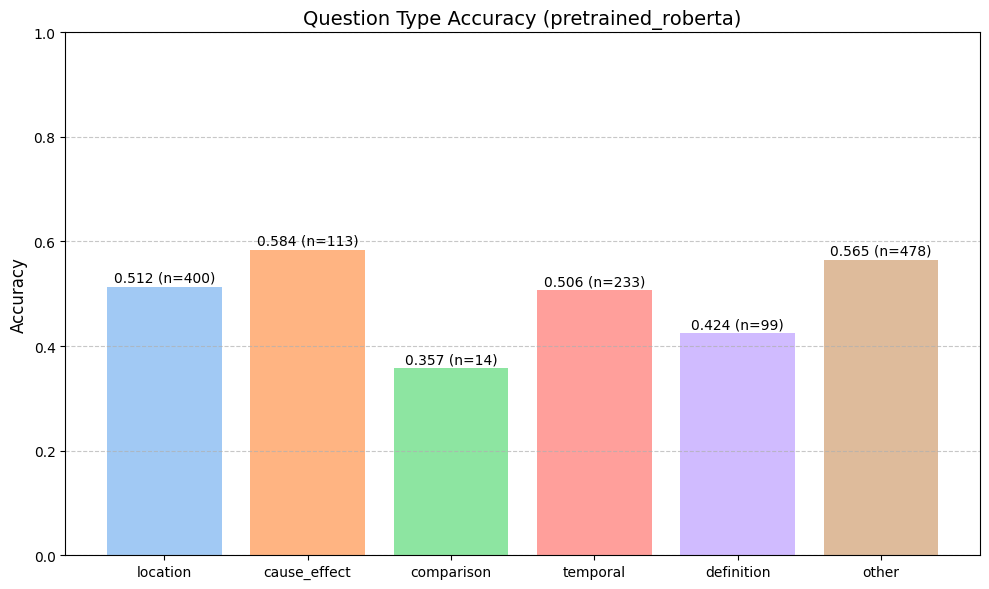

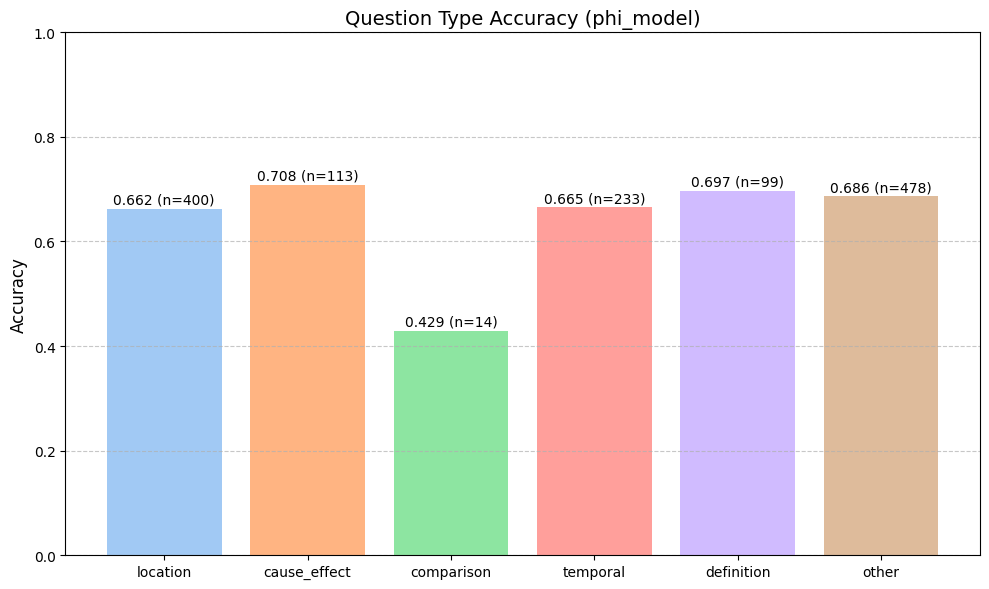

In [59]:
def plot_question_type_analysis(results, model_name):
    categories = list(results.keys())
    accuracies = [results[cat]["correct"] / results[cat]["total"] if results[cat]["total"] > 0 else 0 for cat in categories]
    counts = [results[cat]["total"] for cat in categories]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, accuracies, color=sns.color_palette("pastel"))
    plt.ylim(0, 1.0)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f"Question Type Accuracy ({model_name})", fontsize=14)
    plt.xticks()

    for bar, acc, count in zip(bars, accuracies, counts):
        plt.text(bar.get_x() + bar.get_width()/2.,
                 bar.get_height() + 0.01, 
                 f'{acc:.3f} (n={count})', 
                 ha='center')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'graphics/{model_name}_question_type_analysis.svg', bbox_inches='tight')
    plt.show()

plot_question_type_analysis(roberta_question_type_results, "pretrained_roberta")
plot_question_type_analysis(phi_question_type_results, "phi_model")

#### Question Length Impact

I analyzed how question length affects model performance by grouping questions into length bins and calculating accuracy for each bin.

The pre-trained DistilRoBERTa model shows a faint relationship between question length and accuracy:
- Accuracy peaks for medium-length questions (around 150 characters)
- Performance drops very long questions (but this might be due to the small sample size)
- Performance is relatively stable for short questions

The Phi-4-mini LLM shows a different pattern:
- Fairly consistent performance across most question lengths (65-70% accuracy)
- A notable spike in accuracy (approximately a 85%) for longer questions (around 175-200 characters), though it was unable to answer the two longest questions
- No significant performance degradation for very short questions

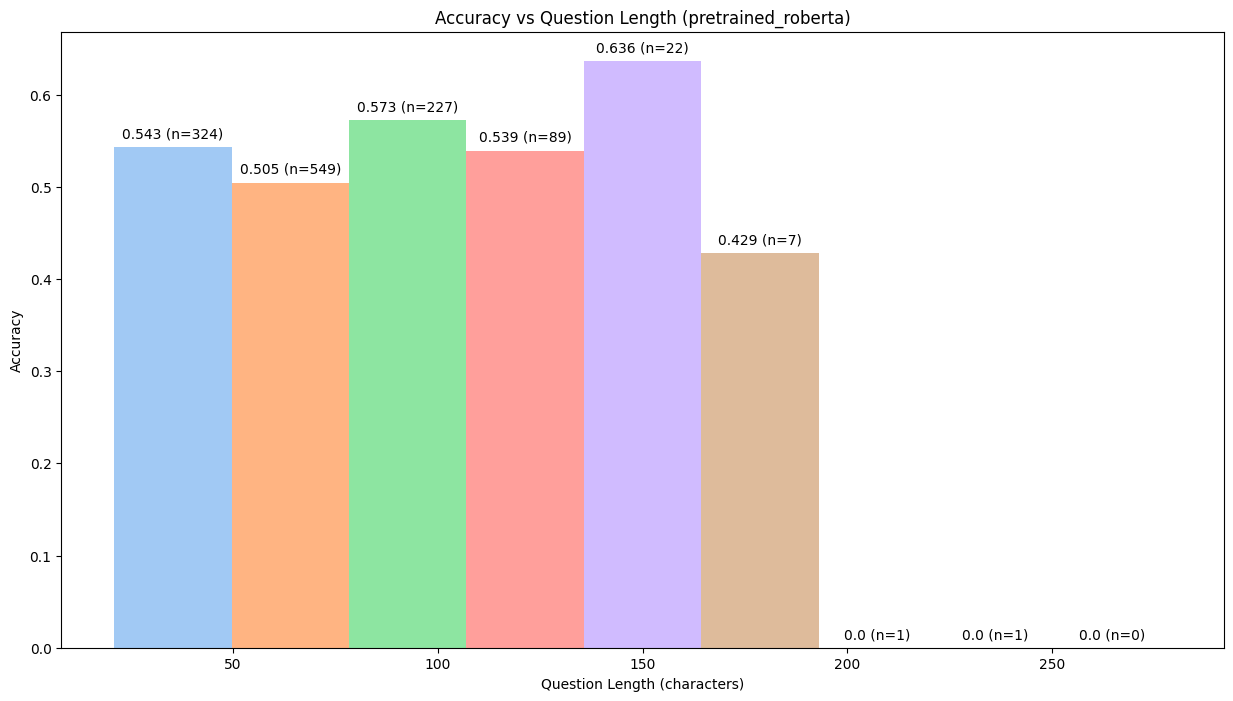

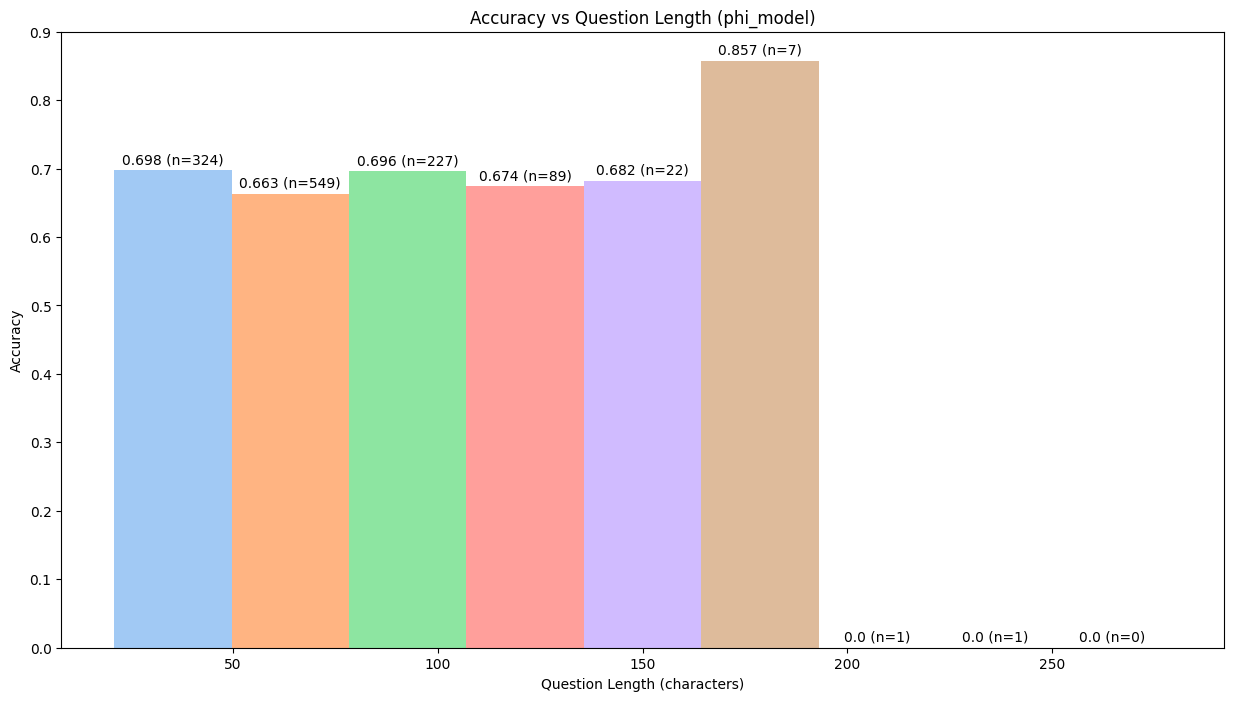

In [60]:
def analyze_by_question_length(test_data, preds, correct_answers, model_name):
    question_lengths = [len(ex["question"]) for ex in test_data]
    
    # create length bins (e.g., 0-50, 50-100, etc.)
    bins = np.linspace(min(question_lengths), max(question_lengths), 10)
    digitized = np.digitize(question_lengths, bins)
    
    # calculate accuracy per bin
    bin_correct = np.zeros(len(bins))
    bin_total = np.zeros(len(bins))
    
    for (length_bin, pred, true) in zip(digitized, preds, correct_answers):
        bin_total[length_bin-1] += 1
        if pred == true:
            bin_correct[length_bin-1] += 1
    
    bin_accuracy = np.divide(bin_correct, bin_total, out=np.zeros_like(bin_correct), where=bin_total!=0)
    
    plt.figure(figsize=(15, 8))
    plt.bar(bins[:-1], bin_accuracy[:-1], width=np.diff(bins), align='edge', color=sns.color_palette("pastel"))
    plt.xlabel('Question Length (characters)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Question Length ({model_name})')
    
    # Add counts on top of bars
    for i in range(len(bins)-1):
        plt.text(bins[i] + (bins[i+1]-bins[i])/2, bin_accuracy[i] + 0.01, 
                 f"{bin_accuracy[i]:.3} (n={int(bin_total[i])})", ha='center')
    
    plt.savefig(f'graphics/{model_name}_accuracy_vs_length.svg')
    plt.show()

analyze_by_question_length(test, pretrained_test_preds, pretrained_test_labels, "pretrained_roberta")
analyze_by_question_length(test, phi_test_preds, phi_test_labels, "phi_model")

### Answer Choice Bias

I examined whether models show biases toward certain answer choices (A-E) and how these biases affect performance.

The pre-trained Transformer shows:
- A relatively balanced distribution of predictions across choices, with a slight preference for option A
- Slight under-prediction of option E
- Highest accuracy for answer choices A and B (~57%)
- Lower accuracy for choices C, D, and E (~48-52%)

The Phi-4-mini LLM shows:
- Strong bias against predicting option E (predicted 93 times vs. 235 in ground truth)
- Over-prediction of options B and C
- Highest accuracy for answer choice B (~81%)
- Notably lower accuracy for answer choice E (~32%)

The significant bias against option E could be addressed by further adjusting the prompt or by shuffling the answer choices in the prompt.

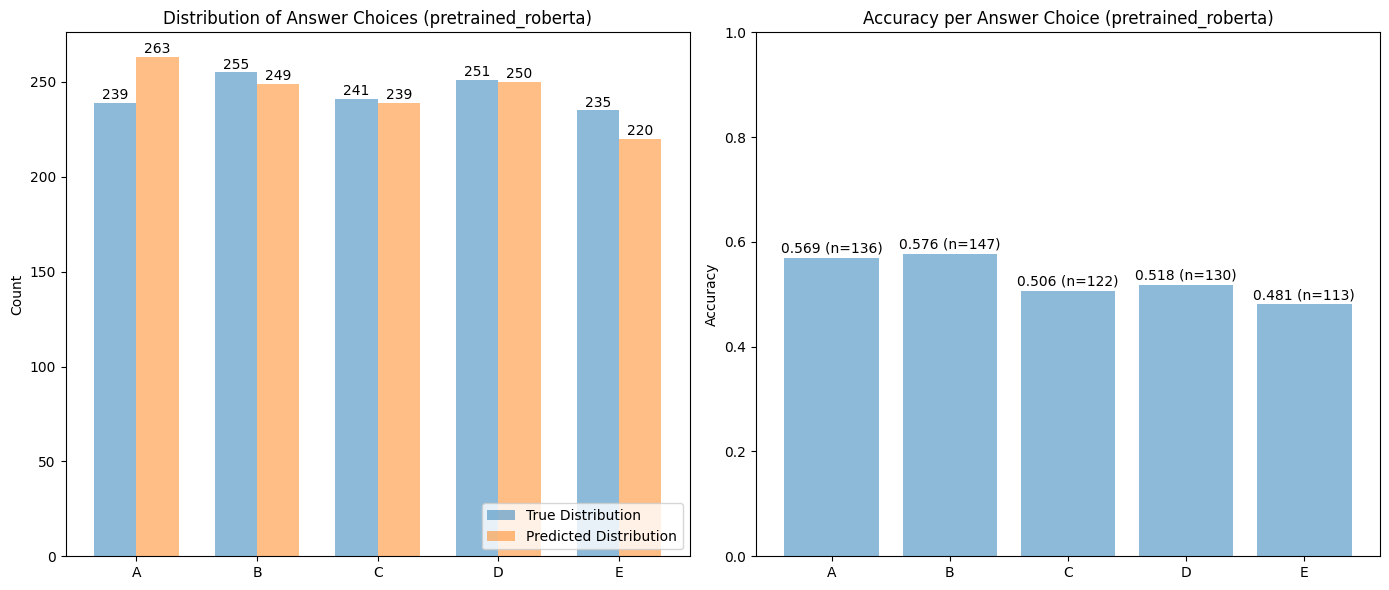

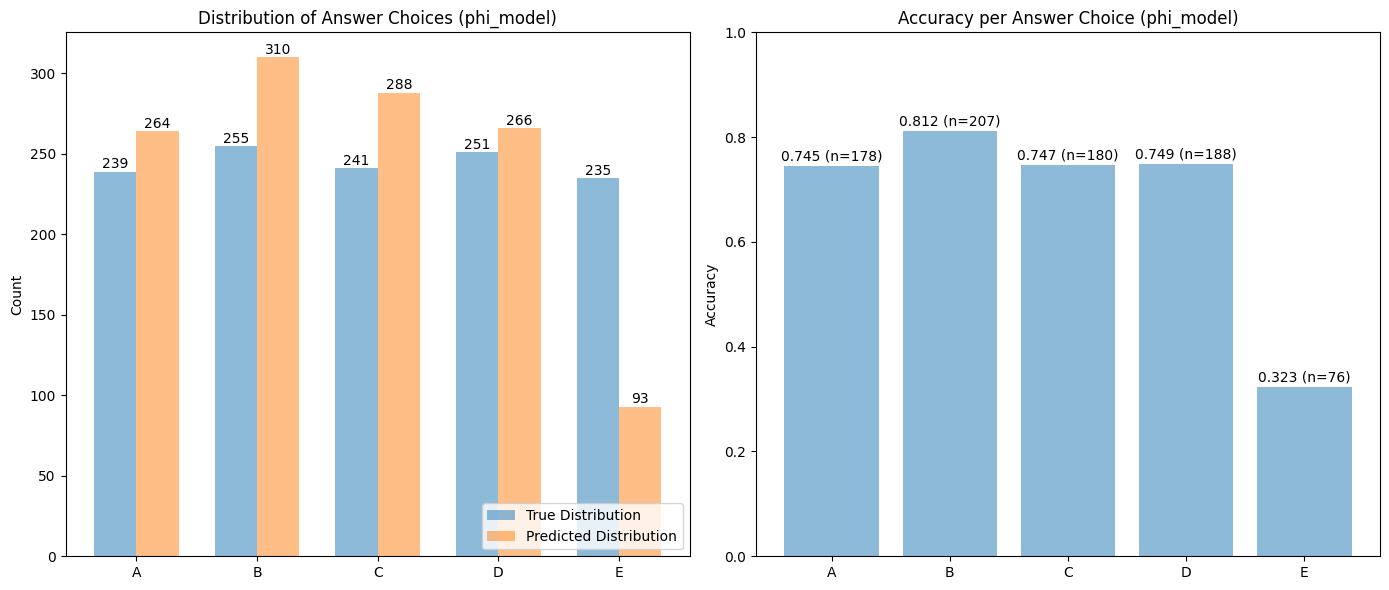

In [ ]:
def analyze_answer_choice_bias(preds, true_labels, model_name):
    pred_counts = [0, 0, 0, 0, 0]  # A, B, C, D, E
    true_counts = [0, 0, 0, 0, 0]
    correct_counts = [0, 0, 0, 0, 0]
    
    for pred, true in zip(preds, true_labels):
        pred_counts[pred] += 1
        true_counts[true] += 1
        if pred == true:
            correct_counts[true] += 1
    
    choice_accuracy = []
    for i in range(5):
        acc = correct_counts[i] / true_counts[i] if true_counts[i] > 0 else 0
        choice_accuracy.append(acc)
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    labels = ['A', 'B', 'C', 'D', 'E']
    x = np.arange(len(labels))
    width = 0.35
    
    true_distribution_bars = ax1.bar(x - width/2, true_counts, width, alpha=0.5, label='True Distribution')
    predicted_distrivution_bars = ax1.bar(x + width/2, pred_counts, width, alpha=0.5, label='Predicted Distribution')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.set_ylabel('Count')
    ax1.set_title(f'Distribution of Answer Choices ({model_name})')
    ax1.legend(loc="lower right")
    
    for bar, count in zip(true_distribution_bars, true_counts):
        ax1.text(bar.get_x() + bar.get_width()/2., 
                 bar.get_height() + 2, 
                 f'{count}', 
                 ha='center')
        
    for bar, count in zip(predicted_distrivution_bars, pred_counts):
        ax1.text(bar.get_x() + bar.get_width()/2., 
                 bar.get_height() + 2, 
                 f'{count}', 
                 ha='center')

    accuracy_bars = ax2.bar(labels, choice_accuracy, alpha=0.5)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'Accuracy per Answer Choice ({model_name})')

    # Add accuracy values on top of bars
    for bar, acc, count in zip(accuracy_bars, choice_accuracy, correct_counts):
        ax2.text(bar.get_x() + bar.get_width()/2., 
                 bar.get_height() + 0.01, 
                 f'{acc:.3f} (n={count})', 
                 ha='center')
    
    plt.tight_layout()
    plt.savefig(f'graphics/{model_name}_answer_choice_analysis.svg')
    plt.show()

analyze_answer_choice_bias(pretrained_test_preds, pretrained_test_labels, "pretrained_roberta")
analyze_answer_choice_bias(phi_test_preds, phi_test_labels, "phi_model")

#### Model Confidence (for Transformer)

For the pre-trained Transformer model, I analyzed the relationship between prediction confidence and accuracy and how well the model is calibrated.
The analysis shows:
- Average confidence for correct predictions is 90.3%
- Average confidence for incorrect predictions is 80.3%
- Most predictions cluster at high confidence values (near 1.0)
- The calibration curve shows significant overconfidence (predicted probabilities always higher than true probabilities)

The model is generally overconfident in its predictions, with relatively small differences in confidence between correct and incorrect predictions. The calibration curve stays well below the ideal diagonal line, indicating poor calibration – when the model predicts with 80-100% confidence, the true accuracy is only 40-65%.

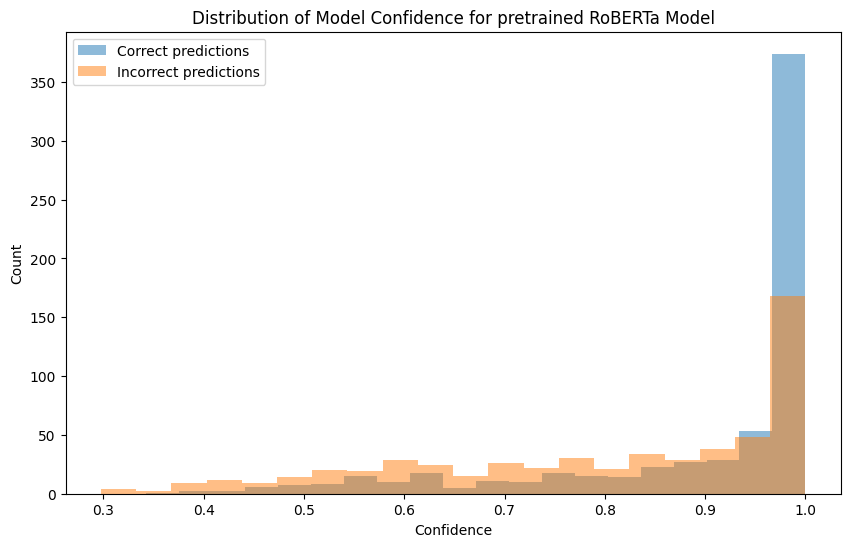

Average confidence for correct predictions: 0.9034
Average confidence for incorrect predictions: 0.8033


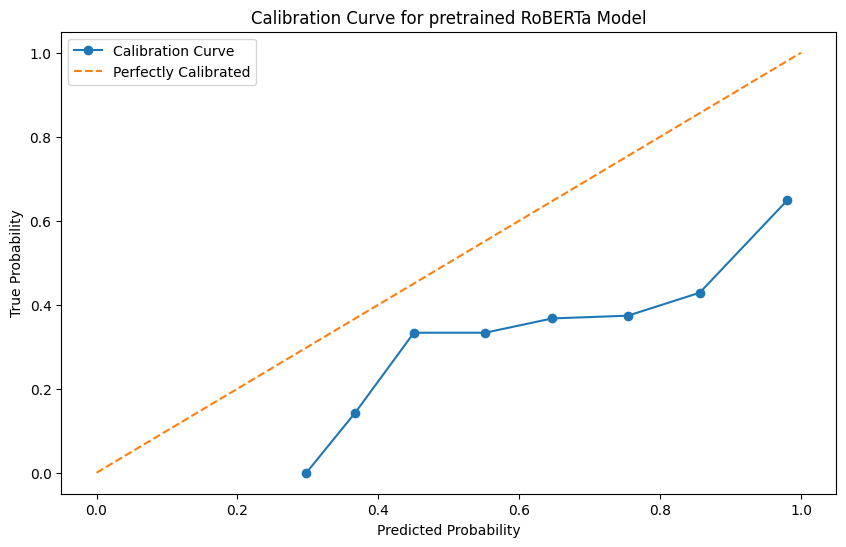

In [62]:
def analyze_confidence(preds, confidences, true_labels):
    correct = [conf for pred, conf, true in zip(preds, confidences, true_labels) if pred == true]
    incorrect = [conf for pred, conf, true in zip(preds, confidences, true_labels) if pred != true]
    
    plt.figure(figsize=(10, 6))
    plt.hist(correct, alpha=0.5, label='Correct predictions', bins=20)
    plt.hist(incorrect, alpha=0.5, label='Incorrect predictions', bins=20)
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title('Distribution of Model Confidence for pretrained RoBERTa Model')
    plt.legend()
    plt.savefig('graphics/confidence_distribution.svg')
    plt.show()
    
    print(f"Average confidence for correct predictions: {np.mean(correct):.4f}")
    print(f"Average confidence for incorrect predictions: {np.mean(incorrect):.4f}")
    
    is_correct = [1 if pred == true else 0 for pred, true in zip(preds, true_labels)]
    prob_true, prob_pred = calibration_curve(is_correct, confidences, n_bins=10)
    
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve for pretrained RoBERTa Model')
    plt.legend()
    plt.savefig('graphics/calibration_curve.svg')
    plt.show()

analyze_confidence(pretrained_test_preds, pretrained_test_confidences, pretrained_test_labels) 

#### Diffcult Examples

I identified questions that both models answered incorrectly.
The analysis found 245 examples that both models got wrong, which is approximately 20% of the test set.

There are questions for which no single choice is clearly correct, that even confuse humans (like me). Examples include:

Question: What do people typically do while playing guitar?
- A) cry
- B) hear sounds
- C) singing
- D) arthritis
- E) making music

=> Correct answer is C, both models predicted E. Both options are plausible.

---

Question: A fencing thrust with a sharp sword towards a person would result in what?
-  A) injury
-  B) small cuts
-  C) fever
-  D) competition
-  E) puncture wound

=> Correct answer is E, RoBERTa predictred B and Phi-4 predicted A. All three options are plausible and it's not apparent which one is the most correct.

---

It can also been seen that the models many times predict the same wrong answer.

In [ ]:
def find_challenging_examples(test_data, model1_preds, model2_preds, true_labels):
    challenging = []
    
    for i, (ex, pred1, pred2, true) in enumerate(zip(test_data, model1_preds, model2_preds, true_labels)):
        if pred1 != true and pred2 != true:
            # both models wrong
            challenging.append((i, ex))
    
    return challenging

challenging_examples = find_challenging_examples(test, pretrained_test_preds, phi_test_preds, pretrained_test_labels)

print(f"Found {len(challenging_examples)} examples that both models got wrong")

print("\nSample of challenging examples:")
for i, (idx, ex) in enumerate(challenging_examples[:250]):
    print(f"\nExample {i+1}:")
    print(f"Question: {ex['question']}")
    for j, choice in enumerate(ex['choices']['text']):
        print(f"{chr(65+j)}) {choice}")
    print(f"Correct Answer: {ex['answerKey']}")
    print(f"RoBERTa prediction: {index_to_answer_key(pretrained_test_preds[idx])}")
    print(f"Phi-4 prediction: {index_to_answer_key(phi_test_preds[idx])}")

Found 245 examples that both models got wrong

Sample of challenging examples:

Example 1:
Question: James was looking for a good place to buy farmland.  Where might he look?
A) midwest
B) countryside
C) estate
D) farming areas
E) illinois
Correct Answer: A
RoBERTa prediction: B
Phi-4 prediction: D

Example 2:
Question: What do people typically do while playing guitar?
A) cry
B) hear sounds
C) singing
D) arthritis
E) making music
Correct Answer: C
RoBERTa prediction: E
Phi-4 prediction: E

Example 3:
Question: Aside from water and nourishment what does your dog need?
A) bone
B) charm
C) petted
D) lots of attention
E) walked
Correct Answer: D
RoBERTa prediction: C
Phi-4 prediction: C

Example 4:
Question: A fencing thrust with a sharp sword towards a person would result in what?
A) injury
B) small cuts
C) fever
D) competition
E) puncture wound
Correct Answer: E
RoBERTa prediction: B
Phi-4 prediction: A

Example 5:
Question: Though the thin film seemed fragile, for it's intended purpose 

## Interpretation

### Expectations

After the mediocre performance of the models of project 1 I expected a clear improvement in terms of the maximum accuracy of the models in this project.
The Transformer architecute (which is also the basis for the LLM) is much more suited to understand language than the RNNs used in project 1.
The preetraining of the models on a large dataset should further boost the performance.

I expected the LLM to outperform the encoder-only Transformers as it is trained on a much larger dataset and has much more parameters.
I also expected the pretrained Transformer to outperform the randomly initialized one, as the randomly initialized one would need much more training data to learn the intrinsics of human language.

The best baseline reported in the original ommensenseQA paper (Talmor et al., 2019) is 56% and was reached using BERT-large.
I thus expected accuracy to be around 80%-90% for the LLM (matching human performance) and around 60%-70% for the pretrained Transformer, because RoBERTa is an improved variant of BERT.
For the randomly initialized one I expected a pretty random performance around 18%-25%, same as the RNN in project 1.

### Results

As expected, the randomly initialized Transformer performed significantly worse than the pretrained one, with a performance at chance level.
The amount of data was much too small for training a model from scratch (compare the training of BERT on ~3.3B words).

Both the pretrained Transformer and the LLM performed significantly better than the randomly initialized one and both the models (Embeddings & RNN) from project 1.
However, with a test-set accuracy of 52.2% for the pretrained Transformer and 67.8% for the LLM, the performance is still not as high as I expected and still doesn not reach human performance.

### Prompt Engineering

The effects of using different prompts and promt styles for the LLM was smaller than expected.
I wasn't able to get any meaningful improvement by using more complex prompts or by adding more examples.
The only variable that changed a lot with the prompt was the time it took to evaluate the model because it increased the number of tokens in the prompt and the model's output.

I was not able to get the model to always output only the letter of the answer choice, despite mentioning it multiple times in the prompt.
It sometimes included multiple choices ("A, or B") or the full answer choice ("A: making music").
This might be due to the model being uncertain about the correct answer and trying to hedge its response, despite the instruction to choose the most appropriate answer if it's not sure.
The model may also be trained to provide more context in its answers, which could explain the longer responses.

### Error Analysis

My most interesting find in the error analysis was that the LLM under-predicts answer choice E.
I'm not completely sure why this is the case, but it could be due to the model being trained different multiple-choice tasks where only 4 answer choices were used.
This could lead to a bias against the fifth answer choice, as the model may not have seen enough examples with five answer choices during training.
It could also be that the model is biased against the last token in the prompt, as it is the last one to be seen and thus the model may not have enough context to make a decision.

Another key point for me was that some questions are genuinely difficult or even impossible to answer correctly.

Last but not least, I found the pretrained RoBERTa model to be overconfident in its predictions, which could be problematic in real-world applications.
This calibration issue is known in the literature and there are methods to improve the calibration of the model, such as Lipschitz Regularization (Ye et al., 2023) or temperature scaling (Guo et al., 2017).

### Conclusion

All in all, I was able to achieve a significant improvement in performance compared to the models from project 1.
The LLM outperformed the pretrained Transformer, which in turn outperformed the randomly initialized one.
However, the results are still not as high as I expected, especially for the pretrained Transformer.

The error analysis showed that the models are not perfect and that there is still room for improvement.
A LLM with more parameters and / or with reasoning capabilities would probably outperform the Phi-4-mini model.
Also, one could try newer / bigger encoder-only models such as [RoBERTa-XL](https://huggingface.co/facebook/xlm-roberta-xl) or [ModernBERT](https://huggingface.co/papers/2412.13663).

## Tools Used

- Visual Studio Code as IDE
- Python 3.9.21
- GitHub for version control
- Weights & Biases for experiment tracking and hyperparameter optimization
- Claude 3.7 Sonnet for troubleshooting, finding bugs, discussing ideas, writing documentation, and generating code for most visualizations
- Github Copilot for completing code snippets and generating boilerplate code
- Github Copilot Chat for troubleshooting and finding bugs